In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font family to Times New Roman
# import matplotlib.pyplot as plt
# from matplotlib import font_manager

# font_path = 'fig/times.ttf'  # Your font path goes here
# font_manager.fontManager.addfont(font_path)
# prop = font_manager.FontProperties(fname=font_path)

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = prop.get_name()

In [2]:
id = ["14643" "12503" "8413" "8924" "4921" "11674" "14859" "3654" "10213" "11939" "8373" "7019" "3258" "11927" "2517" "1395" "8917" "11836" "4663" "7997" "8197" "13799" "2980" "1110" "10487" "4104" "3335" "5996" "2604" "12779" "3521" "8385" "2764" "13063" "5131" "10589" "10240" "2362" "6750" "1573" "14551" "12445" "14576" "4452" "8200" "12013" "3445" "14183" "8033" "5878" "3712" "2867" "10501" "5368" "3378" "1762" "11420" "3244" "10504" "2612" "3683" "6605" "4050" "12834" "2684" "8075" "669" "10243" "14110" "4912" "7360" "10576" "7747" "4644" "14883" "535" "6529" "10480" "6759" "7038" "451" "14023" "5396" "13849" "1735" "14700" "13117" "1815" "1740" "8569" "796" "4825" "12520" "14412" "996" "2190" "3211" "6786" "314" "4491"]


In [108]:
df = pd.read_csv('final_results/wandb_export_2023-05-12T20_20_20.880+10_00.csv')

In [109]:
df.columns

Index(['loss', 'archi_num', 'Accuracy', 'ECE'], dtype='object')

In [110]:
# Pivot the DataFrame to create new columns for each loss type
df_pivot = df.pivot(index='archi_num', columns='loss', values=['ECE', 'Accuracy'])

# Flatten the multi-level column names
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]

# Rename the columns to desired names
df_pivot.rename(columns={'ECE_focal': 'focal_ece', 'ECE_mmce': 'mmce_ece',
                         'Accuracy_focal': 'focal_acc', 'Accuracy_mmce': 'mmce_acc'}, inplace=True)

# Reset the index
df_pivot.reset_index(inplace=True)

In [111]:
df_pivot

,archi_num,focal_ece,mmce_ece,focal_acc,mmce_acc
0,314,0.052773,0.027835,90.20,89.89
1,451,0.062006,0.034364,88.62,88.76
2,535,0.050016,0.028635,88.41,87.86
3,669,0.049401,0.030834,89.65,89.06
4,796,0.047891,0.026320,90.34,89.68
...,...,...,...,...,...
95,14576,0.048897,0.023741,91.56,91.04
96,14643,0.041625,0.019272,92.28,91.55
97,14700,0.041815,0.021947,92.69,91.06
98,14859,0.047590,0.027480,90.04,89.10


In [112]:
df_pivot = pd.read_csv('final_results/wandb_export_2023-05-14T13_06_26.399+10_00.csv')

In [119]:
df_pivot.columns = ['archi_num','focal_acc','focal_ece','mmce_acc','mmce_ece']

In [113]:
df = pd.read_csv('public_results/cifar10_results.csv')

In [120]:
# Assuming other_df is the other DataFrame
df_pivot['archi_num'] = df_pivot['archi_num'].astype(str)
df['config'] = df['config'].astype(str)

merged_df = pd.merge(df_pivot, df[['config', 'acc', 'ECE_15']], 
                     left_on='archi_num', right_on='config', how='left')



In [121]:
merged_df

,archi_num,focal_acc,focal_ece,mmce_acc,mmce_ece,config,acc,ECE_15
0,81,86.84,0.038877,87.08,0.025280,81,0.9335,0.042124
1,138,88.01,0.041095,87.50,0.029049,138,0.9366,0.043625
2,203,88.67,0.048370,88.70,0.029130,203,0.9350,0.046512
3,314,90.20,0.052773,89.89,0.027835,314,0.9157,0.052632
4,352,89.42,0.052338,87.39,0.035396,352,0.9349,0.041030
...,...,...,...,...,...,...,...,...
193,14859,90.04,0.047590,89.10,0.027480,14859,0.9332,0.045344
194,14883,90.75,0.044193,89.63,0.023097,14883,0.9172,0.049401
195,15341,92.73,0.043851,91.54,0.018278,15341,0.9344,0.044534
196,15383,91.09,0.046623,90.52,0.023520,15383,0.9337,0.038584


In [122]:
# Rename columns
merged_df.rename(columns={'acc': 'ece_acc', 'ECE_15': 'ece_15'}, inplace=True)

In [123]:
merged_df['ece_acc'] = merged_df['ece_acc']*100

In [125]:
merged_df.columns

Index(['archi_num', 'focal_acc', 'focal_ece', 'mmce_acc', 'mmce_ece', 'config',
       'ece_acc', 'ece_15'],
      dtype='object')

In [126]:
merged_df.columns = ['archi_num', 'Focal_acc', 'Focal_ECE', 'MMCE_acc', 'MMCE_ECE', 'config',
       'CE_acc', 'CE_ECE']

In [127]:
merged_df

,archi_num,Focal_acc,Focal_ECE,MMCE_acc,MMCE_ECE,config,CE_acc,CE_ECE
0,81,86.84,0.038877,87.08,0.025280,81,93.35,0.042124
1,138,88.01,0.041095,87.50,0.029049,138,93.66,0.043625
2,203,88.67,0.048370,88.70,0.029130,203,93.50,0.046512
3,314,90.20,0.052773,89.89,0.027835,314,91.57,0.052632
4,352,89.42,0.052338,87.39,0.035396,352,93.49,0.041030
...,...,...,...,...,...,...,...,...
193,14859,90.04,0.047590,89.10,0.027480,14859,93.32,0.045344
194,14883,90.75,0.044193,89.63,0.023097,14883,91.72,0.049401
195,15341,92.73,0.043851,91.54,0.018278,15341,93.44,0.044534
196,15383,91.09,0.046623,90.52,0.023520,15383,93.37,0.038584


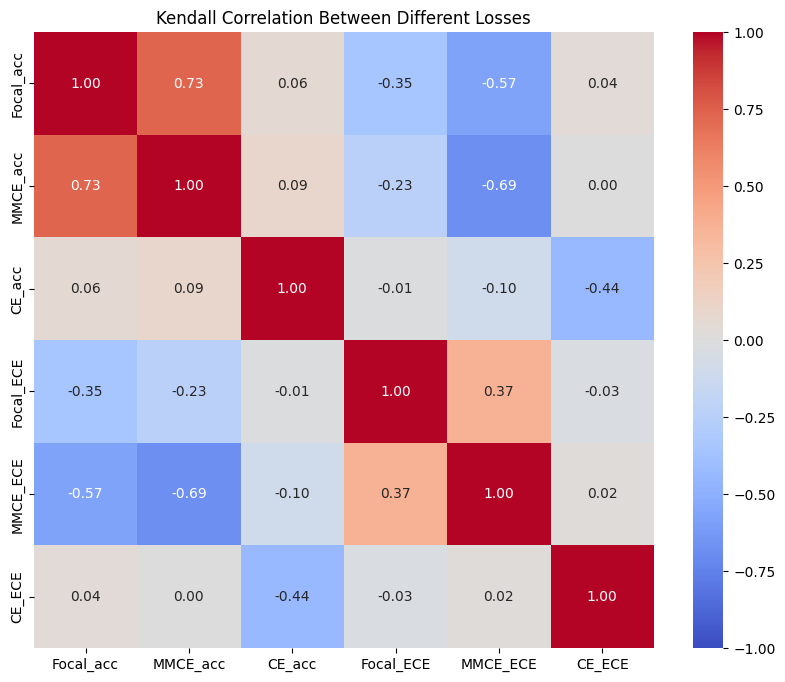

In [130]:
# List of columns to calculate correlation
cols_to_corr = ['Focal_acc', 'MMCE_acc', 'CE_acc','Focal_ECE', 'MMCE_ECE', 'CE_ECE']

# Calculate the correlation
corr = merged_df[cols_to_corr].corr(method='kendall')

# Print the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Kendall Correlation Between Different Losses')

plt.savefig("fig/Kendall_losses_198.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [28]:
import matplotlib.font_manager as fm

# Set the path to the Times New Roman font file
pd.set_option('display.max_colwidth', 1000)

In [29]:

title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16

In [30]:


import pandas as pd
df = pd.read_csv('final_results/cifar10_results.csv')
# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df[['15_bins','100_bins', '200_bins', '500_bins']]



In [31]:
df_post = pd.read_csv('final_results/cifar10_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ecepost_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df[['15_bins','100_bins', '200_bins', '500_bins']]



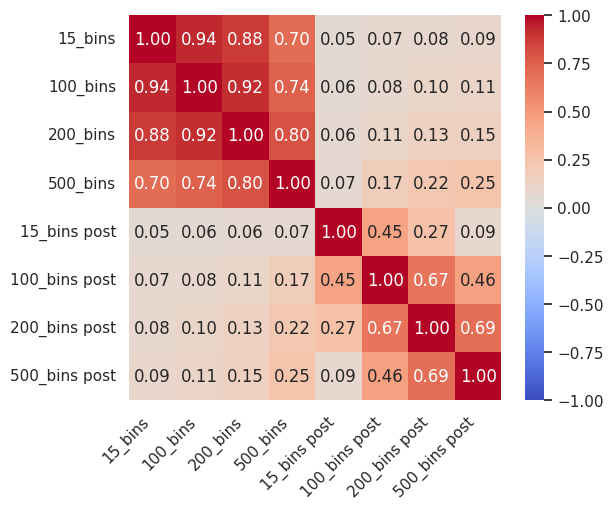

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['15_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_post' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col} post" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df[bin_columns], plotpost_df], axis=1)

# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = bin_columns + [f"{col} post" for col in bin_columns]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)

for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
# plt.title("ImageNet ECE Kendall Ranking Correlation Heatmap ")

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_cifar10_temp_8x8.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [59]:


import pandas as pd
df = pd.read_csv('final_results/cifar10_results.csv')
# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df[['test-accuracy','15_bins','100_bins', '200_bins', '500_bins']]

df_post = pd.read_csv('final_results/cifar10_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ecepost_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df[['15_bins','100_bins', '200_bins', '500_bins']]


In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['15_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_post' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col} post" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df, plotpost_df], axis=1)

combined_df = combined_df.nlargest(1000, 'test-accuracy')[['15_bins', '100_bins', '200_bins', '500_bins' ,'15_bins post', '100_bins post', '200_bins post', '500_bins post']]

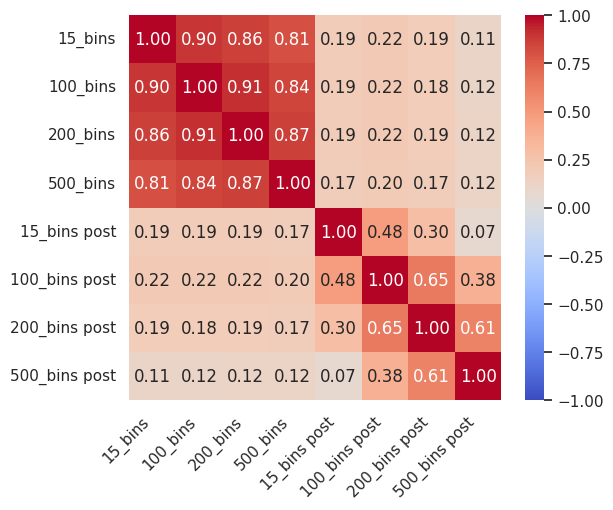

In [75]:
# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = bin_columns + [f"{col} post" for col in bin_columns]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)


for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
# plt.title("ImageNet ECE Kendall Ranking Correlation Heatmap ")

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_cifar10_temp_8x8_top1000.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

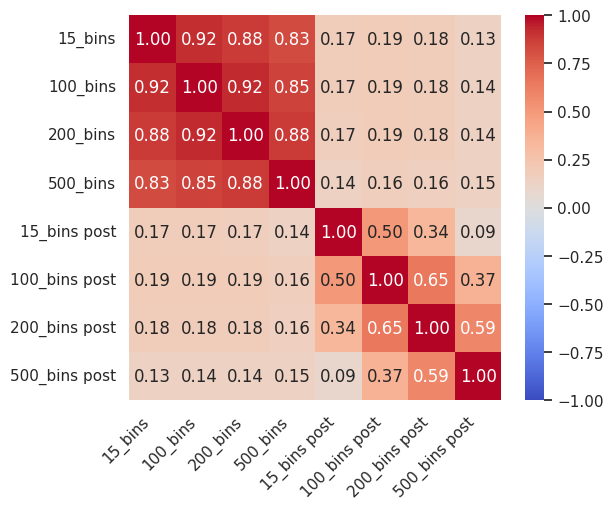

In [76]:


import pandas as pd
df = pd.read_csv('final_results/cifar10_results.csv')
# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df[['test-accuracy','15_bins','100_bins', '200_bins', '500_bins']]

df_post = pd.read_csv('final_results/cifar10_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ecepost_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df[['15_bins','100_bins', '200_bins', '500_bins']]


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['15_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_post' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col} post" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df, plotpost_df], axis=1)

combined_df = combined_df.nlargest(2000, 'test-accuracy')[['15_bins', '100_bins', '200_bins', '500_bins' ,'15_bins post', '100_bins post', '200_bins post', '500_bins post']]

# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = bin_columns + [f"{col} post" for col in bin_columns]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)


for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
# plt.title("ImageNet ECE Kendall Ranking Correlation Heatmap ")

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_cifar10_temp_8x8_top2000.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


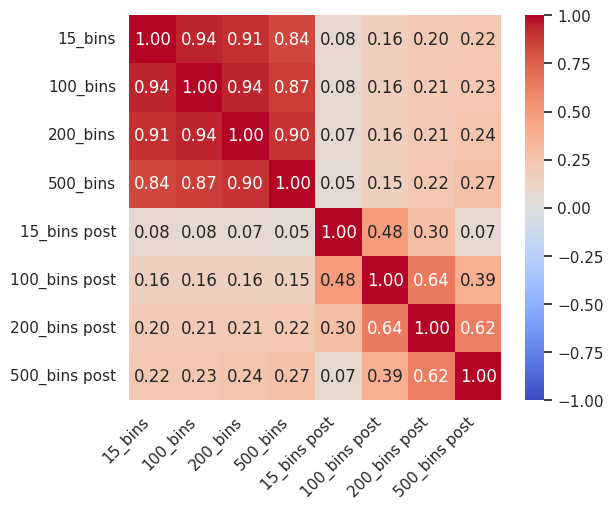

In [77]:


import pandas as pd
df = pd.read_csv('final_results/cifar10_results.csv')
# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df[['test-accuracy','15_bins','100_bins', '200_bins', '500_bins']]

df_post = pd.read_csv('final_results/cifar10_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ecepost_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df[['15_bins','100_bins', '200_bins', '500_bins']]


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['15_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_post' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col} post" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df, plotpost_df], axis=1)

combined_df = combined_df.nlargest(5000, 'test-accuracy')[['15_bins', '100_bins', '200_bins', '500_bins' ,'15_bins post', '100_bins post', '200_bins post', '500_bins post']]

# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = bin_columns + [f"{col} post" for col in bin_columns]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)


for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
# plt.title("ImageNet ECE Kendall Ranking Correlation Heatmap ")

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_cifar10_temp_8x8_top5000.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


In [78]:


import pandas as pd
df = pd.read_csv('final_results/cifar10_results.csv')
# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df[['15_bins','100_bins', '200_bins', '500_bins']]



In [79]:
df_post = pd.read_csv('final_results/cifar10_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ecepost_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df[['15_bins','100_bins', '200_bins', '500_bins']]



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['15_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_post' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col} post" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df[bin_columns], plotpost_df], axis=1)

# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = bin_columns + [f"{col} post" for col in bin_columns]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)

for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
# plt.title("ImageNet ECE Kendall Ranking Correlation Heatmap ")

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

plt.savefig("fig/Kendall_cifar10_temp_8x8.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_cifar10 = pd.read_csv('public_results/cifar10_sss.csv')
df_cifar100 = pd.read_csv('public_results/cifar100_sss.csv')
df_imagenet = pd.read_csv('public_results/imagenet_sss.csv')

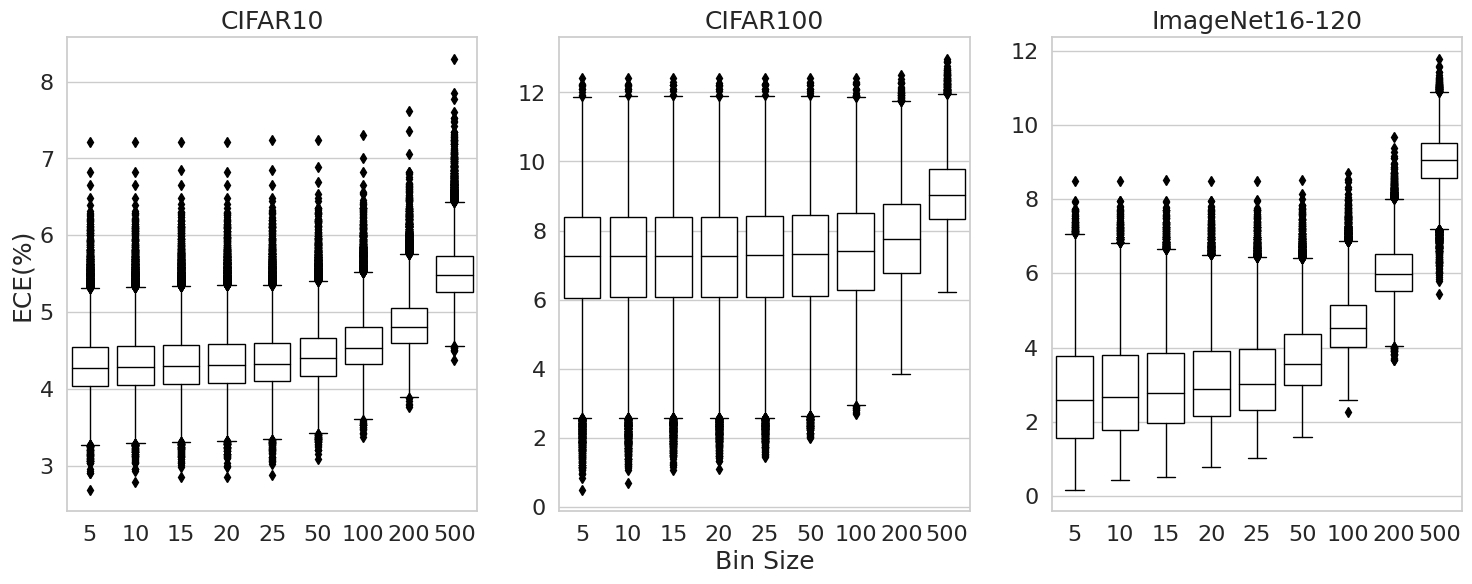

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Top-level, Equal-Width', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'ECE_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=axis_label_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap

plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/toplevel_ew_sss.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

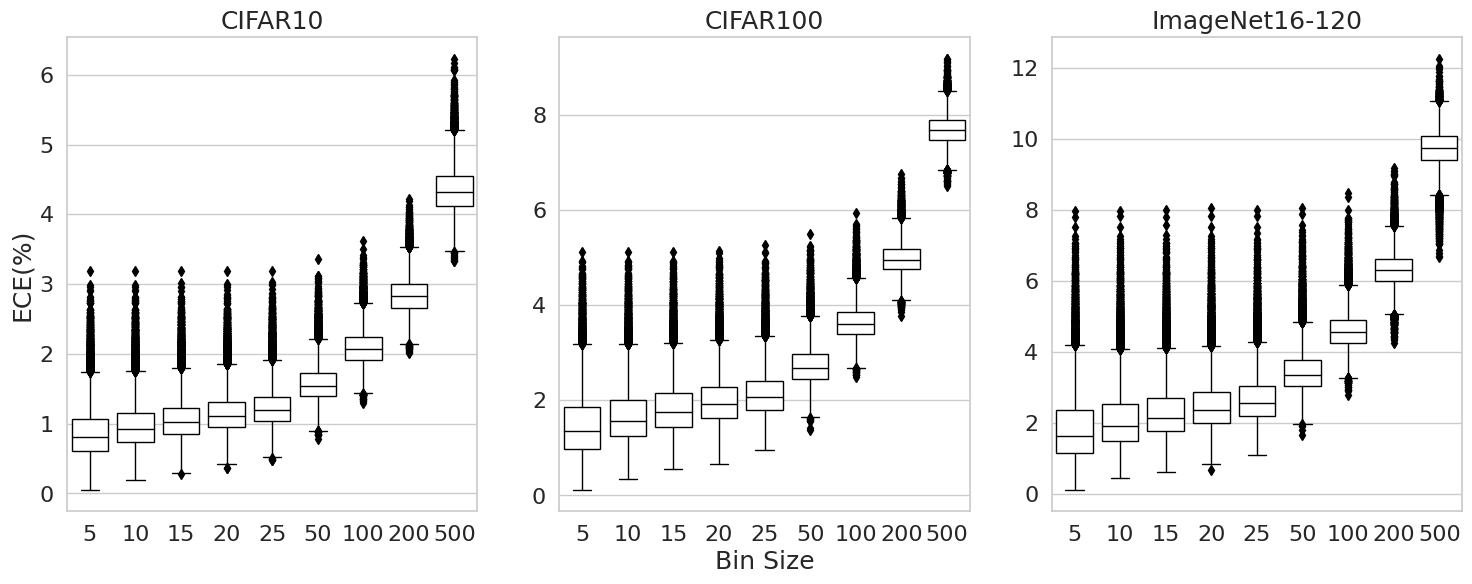

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_cifar10 = pd.read_csv('public_results/cifar10_sss_post.csv')
df_cifar100 = pd.read_csv('public_results/cifar100_sss_post.csv')
df_imagenet = pd.read_csv('public_results/imagenet_sss_post.csv')

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Top-level, Equal-Width', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'ECE_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=axis_label_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap

plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/toplevel_ew_sss_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_cifar10 = pd.read_csv('public_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('public_results/cifar100_results.csv')
df_imagenet = pd.read_csv('public_results/imagenet_results.csv')

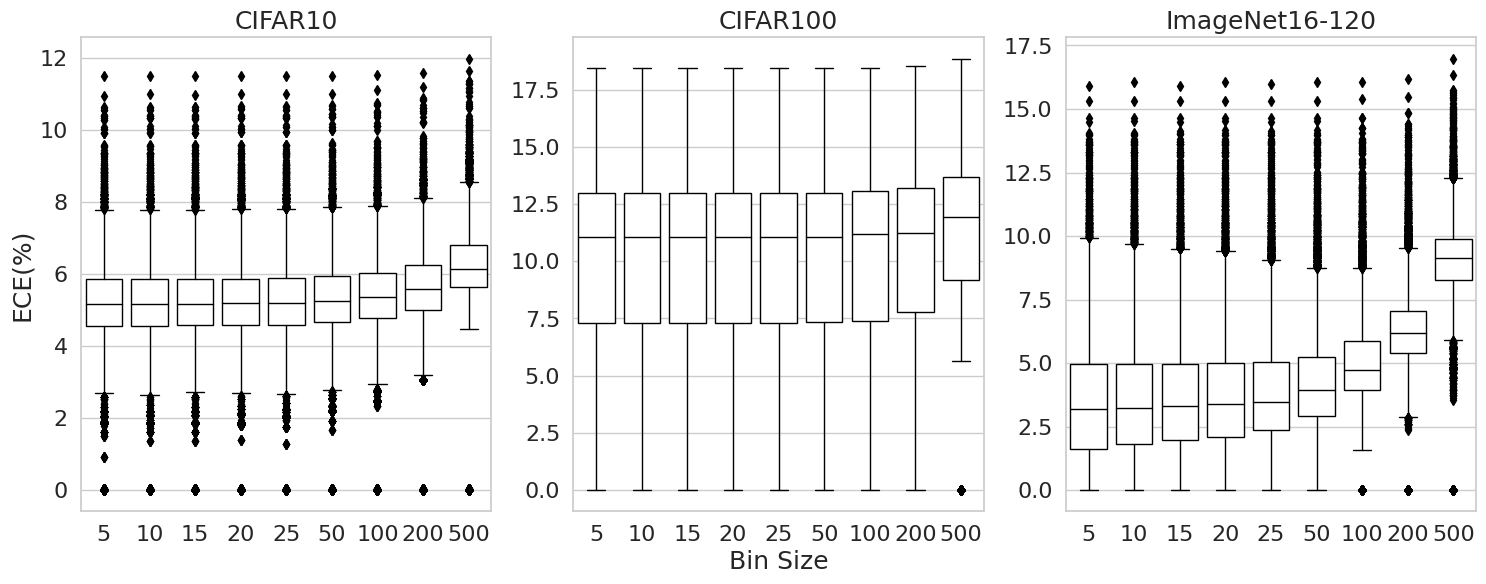

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Top-level, Equal-Width', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'ECE_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=axis_label_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap

plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/toplevel_ew.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

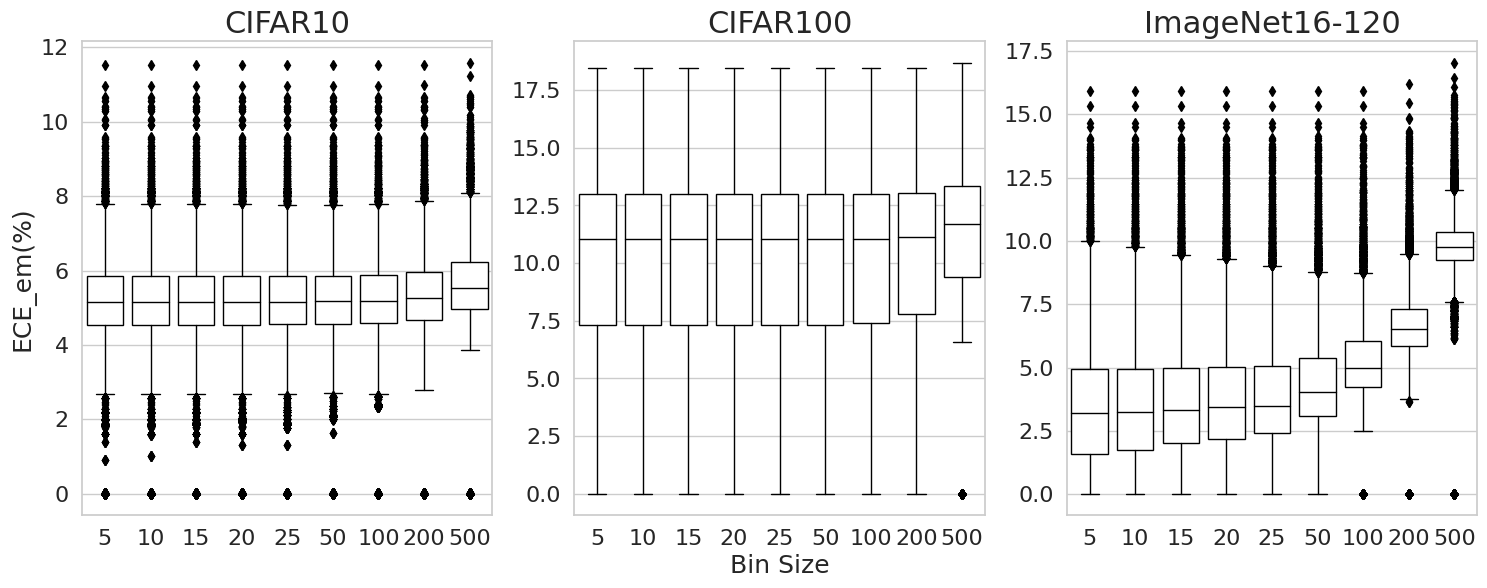

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Top-level, Equal-Mass', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'ECE_em_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE_em(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/toplevel_em.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Top-level, Equal-Mass', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'ECE_em_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE_em(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/toplevel_em.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

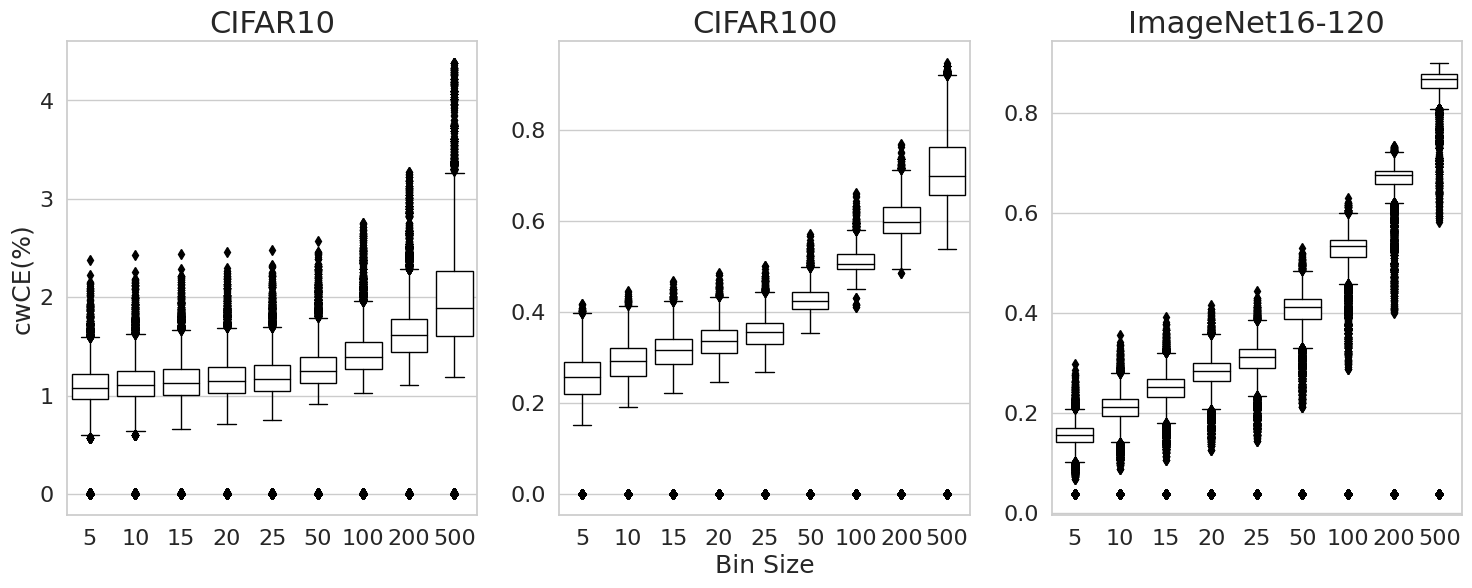

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Classwise, Equal-Width', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'cwCE_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("cwCE(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/classwise_ew.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

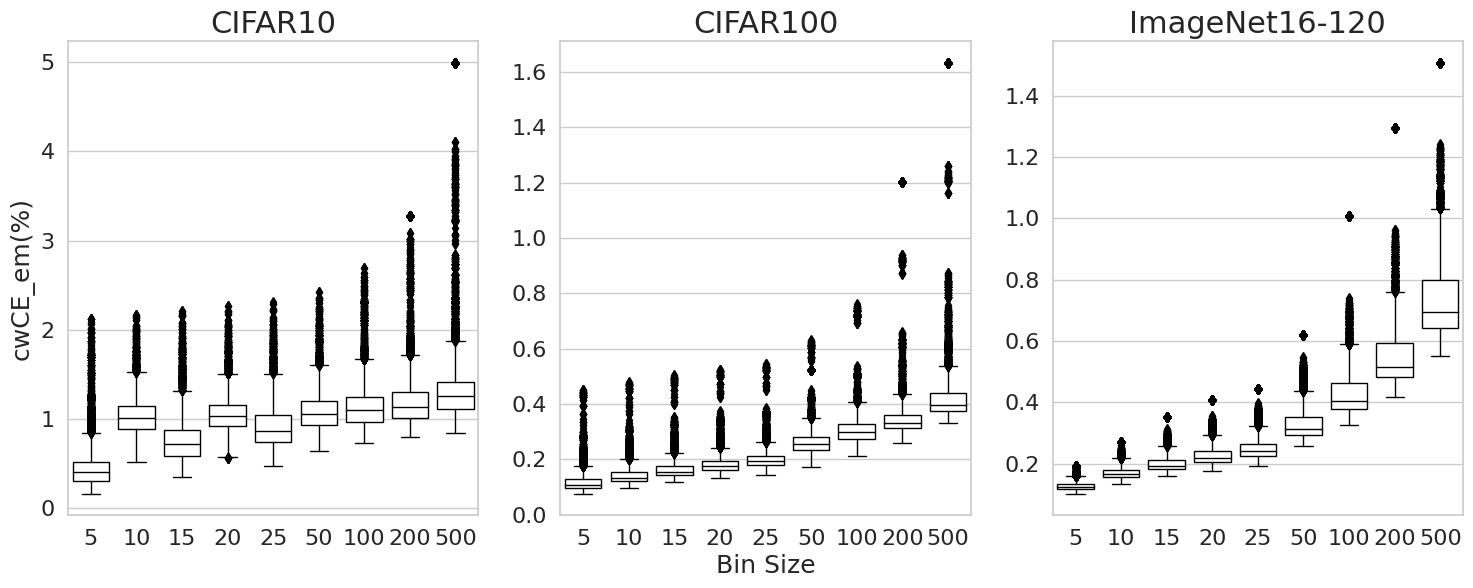

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Classwise, Equal-Mass', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'cwCE_em_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("cwCE_em(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/classwise_em.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_cifar10 = pd.read_csv('public_results/cifar10_post.csv')
df_cifar100 = pd.read_csv('public_results/cifar100_post.csv')
df_imagenet = pd.read_csv('public_results/imagenet_post.csv')

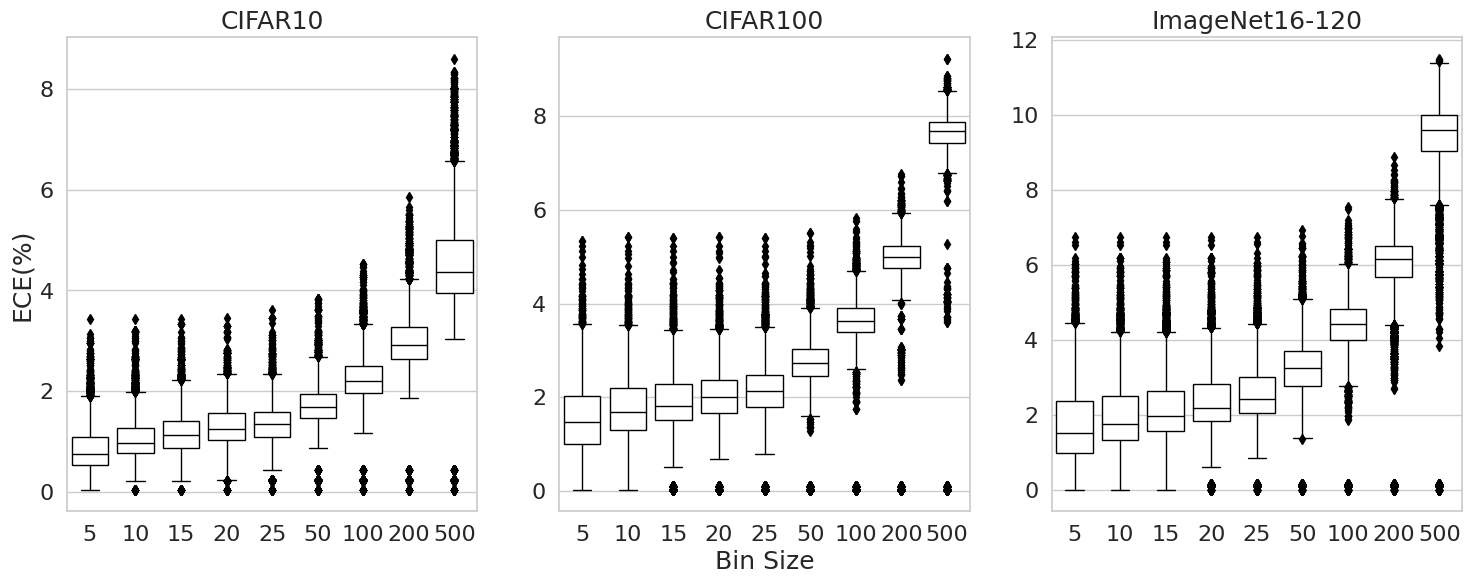

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Top-level, Equal-Width', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'ECE_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=axis_label_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap

plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/toplevel_ew_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

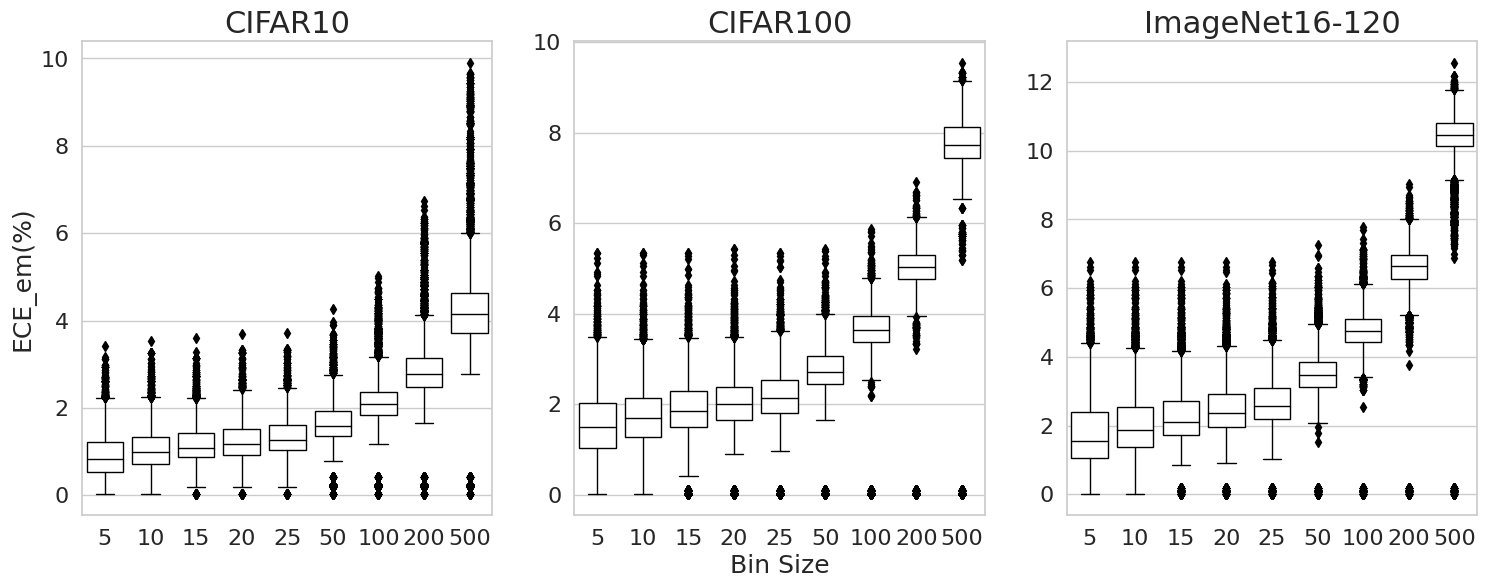

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Top-level, Equal-Mass', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'ECE_em_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE_em(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/toplevel_em_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

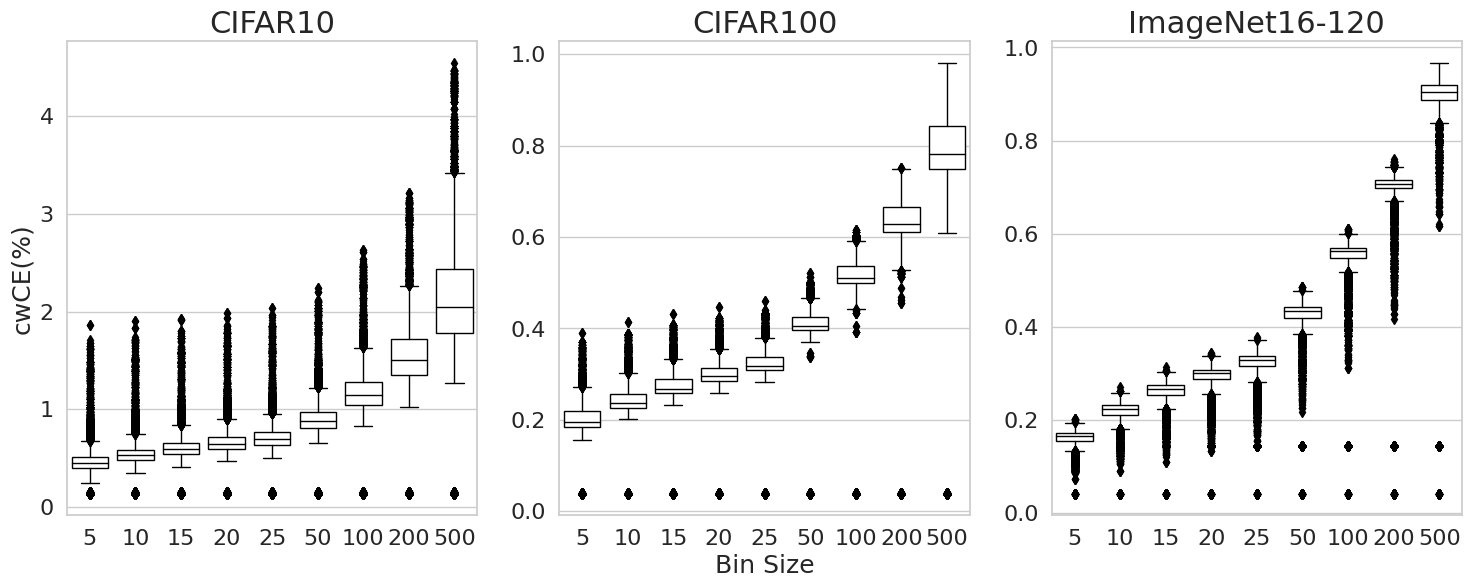

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Classwise, Equal-Width', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'cwCE_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("cwCE(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/classwise_ew_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

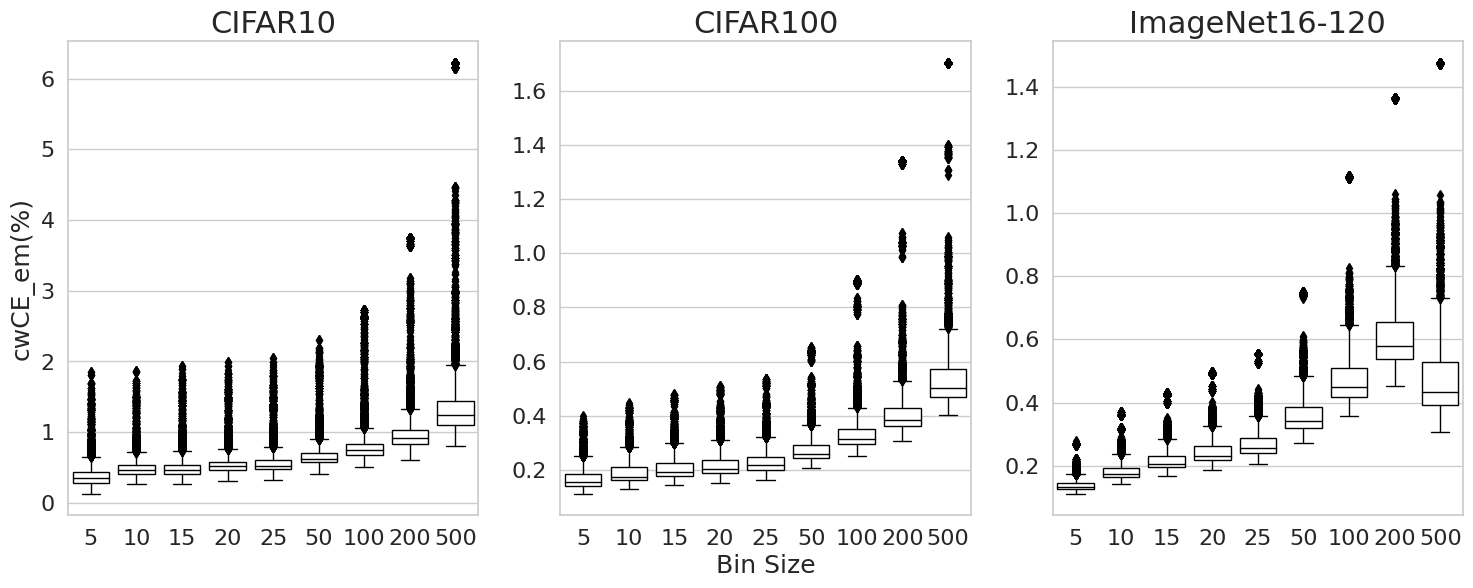

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Classwise, Equal-Mass', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'cwCE_em_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("cwCE_em(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/classwise_em_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_cifar10 = pd.read_csv('archive_results/cifar10_results.csv')
df_cifar100 = pd.read_csv('archive_results/cifar100_results.csv')
df_imagenet = pd.read_csv('archive_results/imagenet_results.csv')

In [2]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df_cifar10 = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_cifar10.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']*100
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    ece_df_cifar10 = pd.concat([ece_df_cifar10, data_to_append], ignore_index=True)

plot_df_cifar10 = ece_df_cifar10


In [3]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df_cifar100 = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_cifar100.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']*100
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    ece_df_cifar100 = pd.concat([ece_df_cifar100, data_to_append], ignore_index=True)

plot_df_cifar100 = ece_df_cifar100


In [4]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df_imagenet = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_cifar100.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']*100
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    ece_df_imagenet = pd.concat([ece_df_imagenet, data_to_append], ignore_index=True)

plot_df_imagenet = ece_df_imagenet


In [5]:
dfs = [plot_df_cifar10, plot_df_cifar100, plot_df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins']
bins = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

In [7]:
title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16

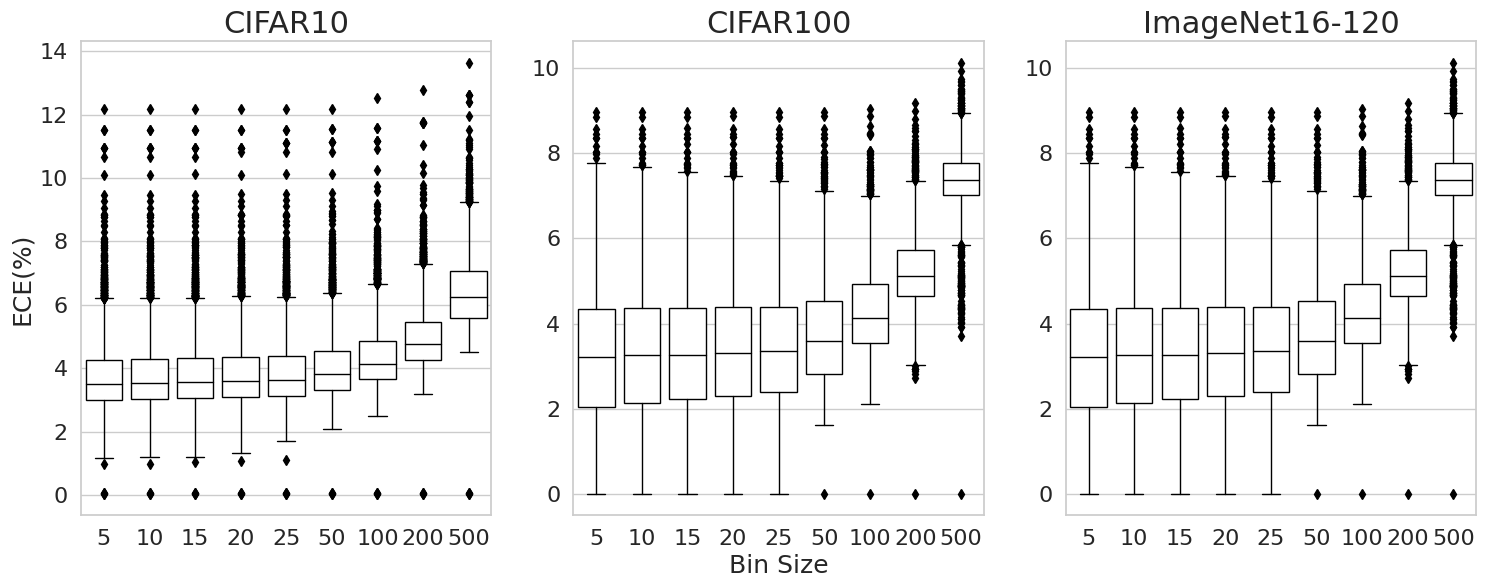

In [9]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols], ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    if i == 1:
        axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)
    else:
        axs[i].set_xlabel("")

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bins, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
# plt.savefig("fig/toplevel_ew_12.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
# plt.title("Top-level, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bin Size", fontsize=14)
plt.ylabel("ECE(%)", fontsize=14)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=12)
plt.yticks(fontsize=12)



plt.savefig("fig/imagenet_smallplot.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

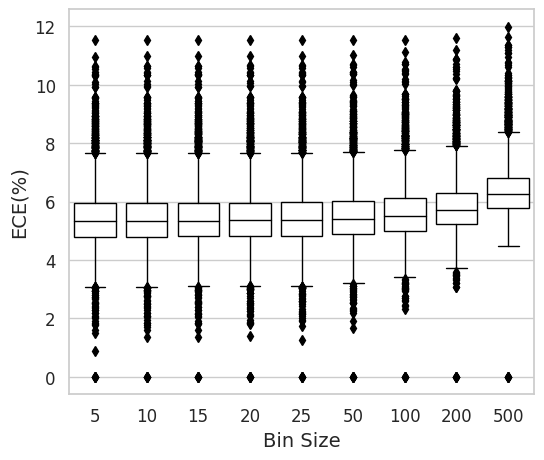

In [207]:
df = pd.read_csv('final_results/cifar10_results.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']*100
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
# plt.title("Top-level, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bin Size", fontsize=14)
plt.ylabel("ECE(%)", fontsize=14)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=12)
plt.yticks(fontsize=12)



plt.savefig("fig/cifar10_ece.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

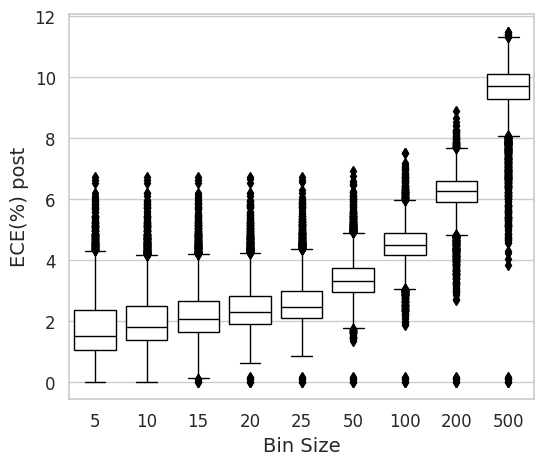

In [208]:
df = pd.read_csv('final_results/imagenet_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']*100
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
# plt.title("Top-level, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bin Size", fontsize=14)
plt.ylabel("ECE(%) post", fontsize=14)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=12)
plt.yticks(fontsize=12)



plt.savefig("fig/cifar10_ece_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

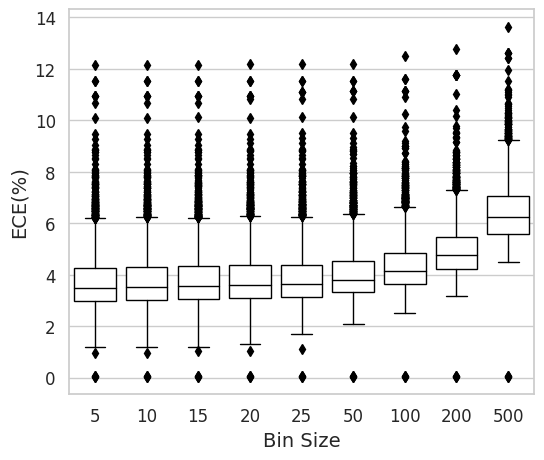

In [243]:
df = pd.read_csv('archive_results/cifar10_results.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']*100
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
# plt.title("Top-level, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bin Size", fontsize=14)
plt.ylabel("ECE(%)", fontsize=14)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=12)
plt.yticks(fontsize=12)



plt.savefig("fig/cifar10_ece_12epochs.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

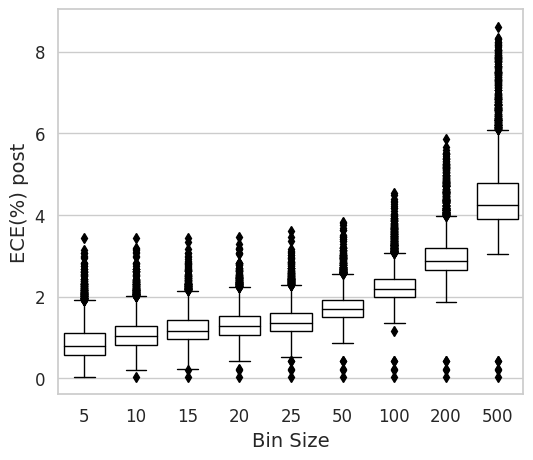

In [209]:
df = pd.read_csv('final_results/cifar10_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']*100
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
# plt.title("Top-level, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bin Size", fontsize=14)
plt.ylabel("ECE(%) post", fontsize=14)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=12)
plt.yticks(fontsize=12)



plt.savefig("fig/cifar100_ece_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

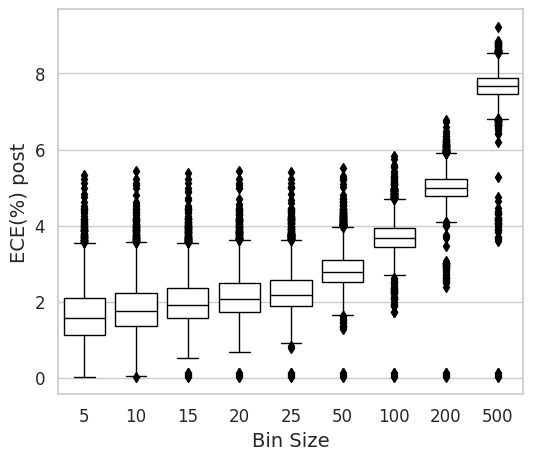

In [210]:
df = pd.read_csv('final_results/cifar100_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']*100
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
# plt.title("Top-level, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bin Size", fontsize=14)
plt.ylabel("ECE(%) post", fontsize=14)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=12)
plt.yticks(fontsize=12)



plt.savefig("fig/imagenet_ece_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

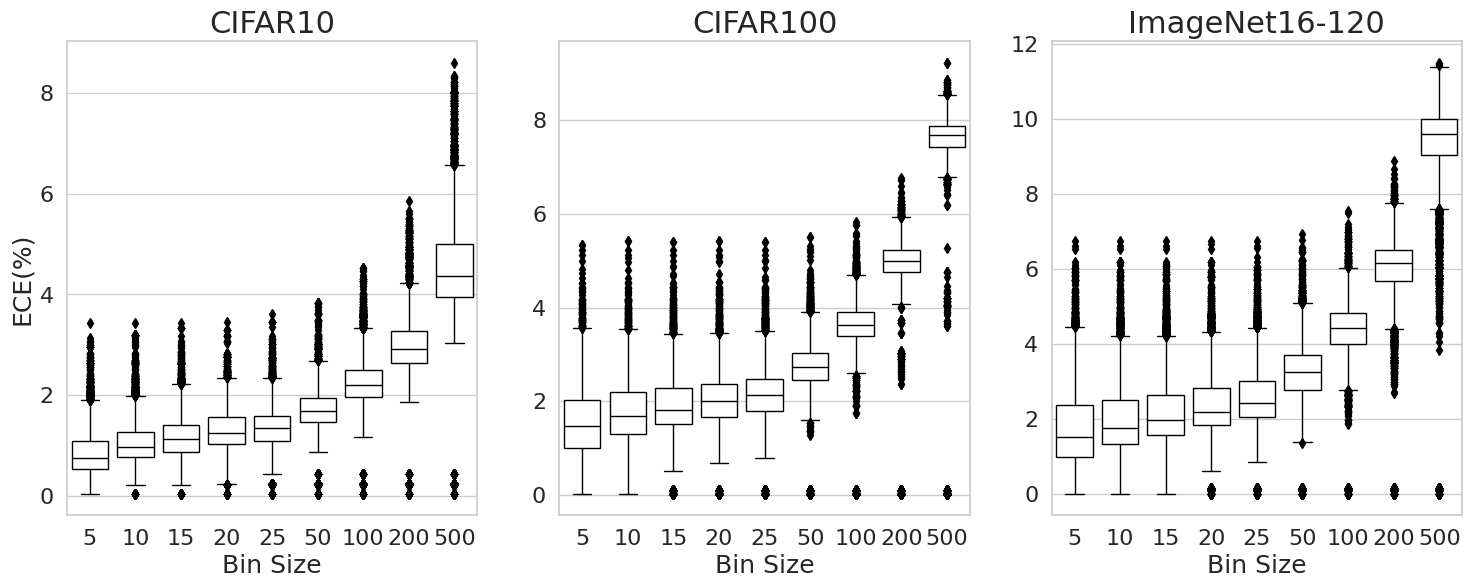

In [211]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_cifar10 = pd.read_csv('public_results/cifar10_post.csv')
df_cifar100 = pd.read_csv('public_results/cifar100_post.csv')
df_imagenet = pd.read_csv('public_results/imagenet_post.csv')
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cifar10, df_cifar100, df_imagenet are the dataframes
dfs = [df_cifar10, df_cifar100, df_imagenet]
datasets = ['CIFAR10', 'CIFAR100', 'ImageNet16-120']
bin_numbers = ['5', '10', '15', '20', '25', '50', '100', '200', '500']

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set a total title for the figure
# fig.suptitle('Top-level, Equal-Mass', fontsize=24, y=1.05)

# Loop through the dataframes
for i, df in enumerate(dfs):
    # Extract ECE columns
    ece_cols = [f'ECE_{bin_num}' for bin_num in bin_numbers]

    sns.boxplot(data=df[ece_cols]*100, ax=axs[i],
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    axs[i].set_title(datasets[i], fontsize=title_font_size)

    # Set x-axis labels only for the second plot
    axs[i].set_xlabel("Bin Size", fontsize=axis_label_font_size)

    # Set y-axis label only for the first plot
    if i == 0:
        axs[i].set_ylabel("ECE(%)", fontsize=axis_label_font_size)
    else:
        axs[i].set_ylabel("")

    # Set x-axis labels
    axs[i].set_xticks(range(len(bin_numbers)))
    axs[i].set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    axs[i].tick_params(axis='y', labelsize=tick_label_font_size)

# Adjust subplot params so that the subplot titles and figure title do not overlap
plt.subplots_adjust(hspace=0.4, top=0.9)

# Save the figure
plt.savefig("fig/toplevel_post.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

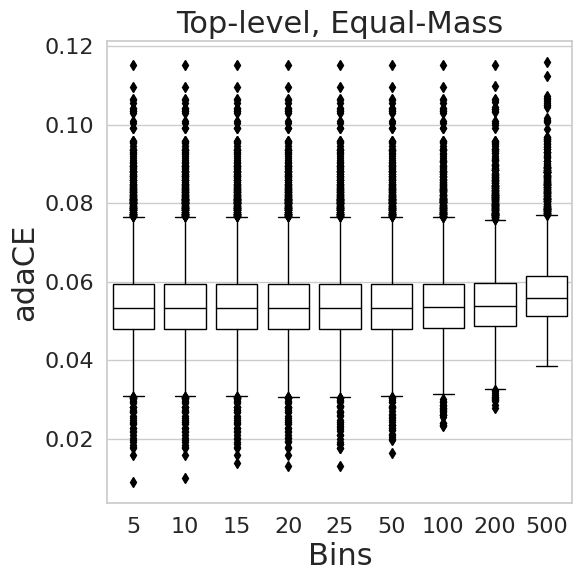

In [31]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
eceem_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ECE_em'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['num_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    eceem_df = pd.concat([eceem_df, data_to_append], ignore_index=True)

plot_df = eceem_df.loc[eceem_df['test-accuracy']>= 75]

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 6))
# Set font sizes

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set plot title and axis labels
plt.title("Top-level, Equal-Mass", fontsize=title_font_size)
plt.xlabel("Bins", fontsize=axis_label_font_size)
plt.ylabel("adaCE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

# plt.savefig("fig/cifar10_toplevel_em_ce.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

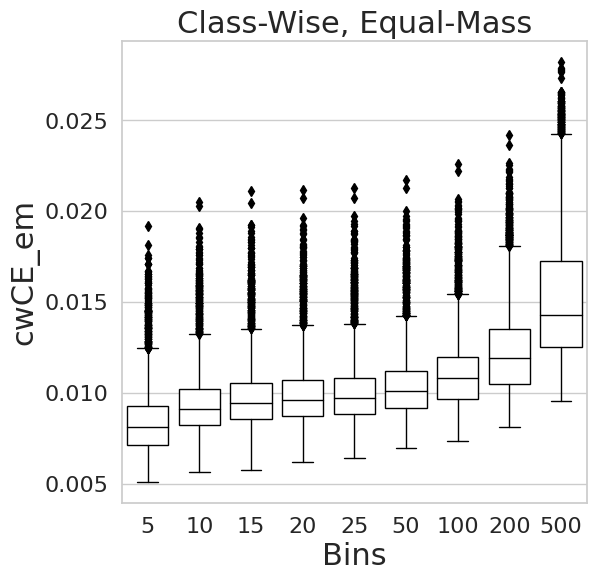

In [33]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
tace_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    tace_data = eval(row['tace'])
    
    bins_data = {}
    for item in tace_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    tace_df = pd.concat([tace_df, data_to_append], ignore_index=True)
plot_df = tace_df.loc[tace_df['test-accuracy']>= 75]

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 6))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set plot title and axis labels

# Set plot title and axis labels
plt.title("Class-Wise, Equal-Mass", fontsize=title_font_size)
plt.xlabel("Bins", fontsize=axis_label_font_size)
plt.ylabel("cwCE_em", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

# plt.savefig("fig/cifar10_classwise_em_ce.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()



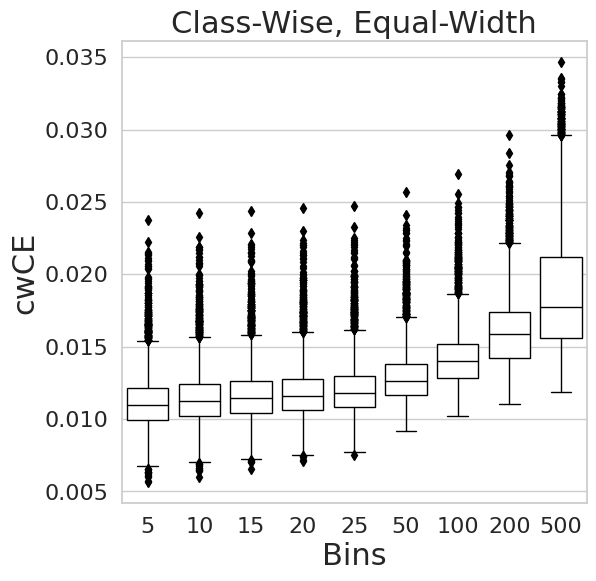

In [35]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
cwECE_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    cwECE_data = eval(row['cwECE'])
    
    bins_data = {}
    for item in cwECE_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    cwECE_df = pd.concat([cwECE_df, data_to_append], ignore_index=True)

plot_df = cwECE_df.loc[cwECE_df['test-accuracy']>= 75]

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 6))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))



# Set plot title and axis labels
plt.title("Class-Wise, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bins", fontsize=axis_label_font_size)
plt.ylabel("cwCE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)


plt.savefig("fig/cifar10_classwise_ew_ce.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()



/home/younan/anaconda3/envs/pytorch_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/younan/anaconda3/envs/pytorch_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/younan/anaconda3/envs/pytorch_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/younan/anaconda3/envs/pytorch_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


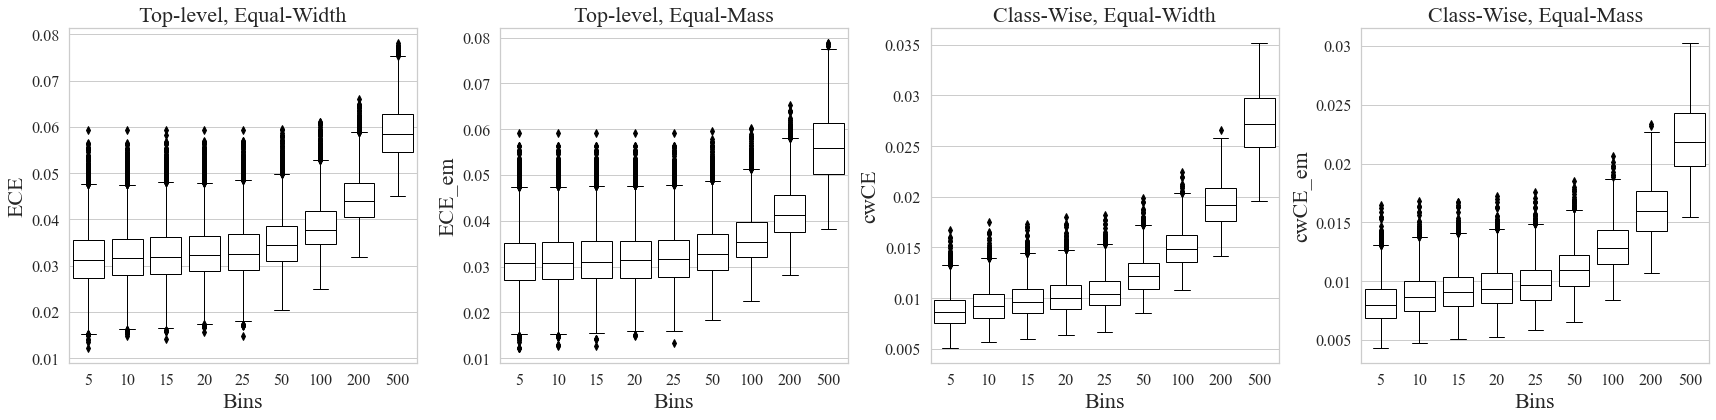

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df, eceem_df, tace_df, cwECE_df are the DataFrames with columns '5_bins', '10_bins', '15_bins', etc.
plot_df_list = [ece_df, eceem_df, cwECE_df, tace_df]
titles = ["Top-level, Equal-Width", "Top-level, Equal-Mass", "Class-Wise, Equal-Width", "Class-Wise, Equal-Mass"]
ylabels = ["ECE", "ECE_em", "cwCE", "cwCE_em"]

# Create a 1x4 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.set(style="whitegrid")

for i, plot_df in enumerate(plot_df_list):
    col = i
    ax = axes[col]

    # Filter data by test-accuracy
    plot_df_filtered = plot_df.loc[plot_df['test-accuracy'] >= 75].iloc[:, :-1]

    # Create a box plot for the plot_df DataFrame
    sns.boxplot(data=plot_df_filtered,
                ax=ax,
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    # Set plot title and axis labels
    ax.set_title(titles[i], fontsize=title_font_size)
    ax.set_xlabel("Bins", fontsize=axis_label_font_size)
    ax.set_ylabel(ylabels[i], fontsize=axis_label_font_size)

    # Modify the x-axis tick labels
    bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
    ax.set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    ax.set_yticklabels(ax.get_yticks(), fontsize=tick_label_font_size)

# Adjust spacing between subplots
fig.tight_layout()

# Save the figure
plt.savefig("fig/cifar10_combined_plots_single_row.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()

/tmp/ipykernel_2425318/17750563.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)
/tmp/ipykernel_2425318/17750563.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)
/tmp/ipykernel_2425318/17750563.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)
/tmp/ipykernel_2425318/17750563.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)


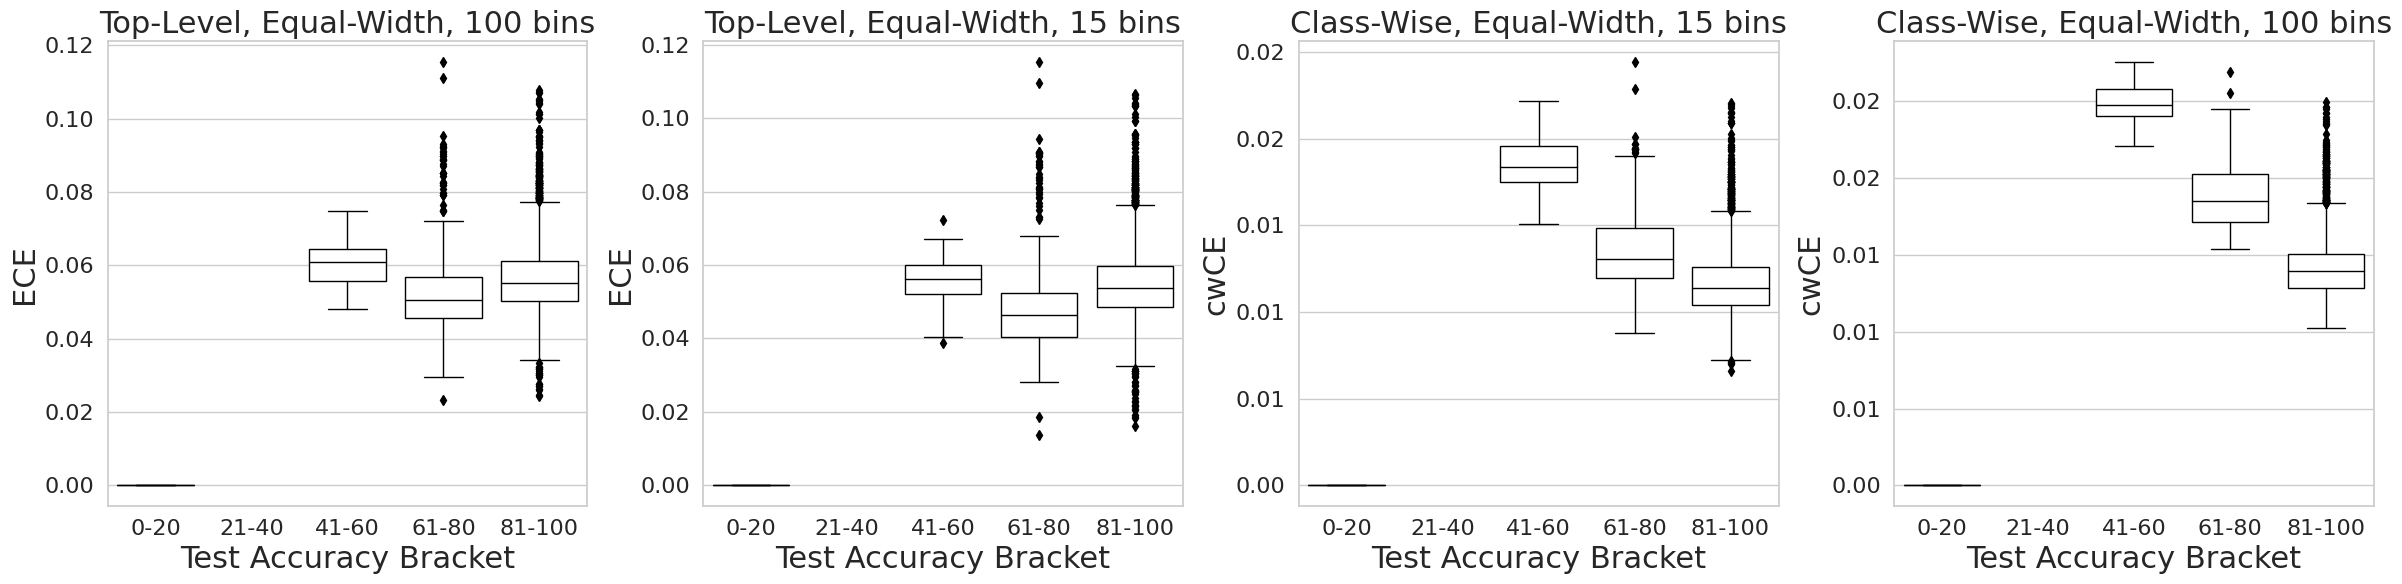

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df and cwECE_df are your dataframes

def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

ece_df['accuracy_bracket'] = ece_df['test-accuracy'].apply(categorize_test_accuracy)
cwECE_df['accuracy_bracket'] = cwECE_df['test-accuracy'].apply(categorize_test_accuracy)

# Create a 1x4 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

sns.set(style="whitegrid")

titles = [
    "Top-Level, Equal-Width, 100 bins",
    "Top-Level, Equal-Width, 15 bins",
    "Class-Wise, Equal-Width, 15 bins",
    "Class-Wise, Equal-Width, 100 bins"
]

ylabels = ["ECE", "ECE", "cwCE", "cwCE"]
bins = ['100_bins', '15_bins', '15_bins', '100_bins']
dataframes = [ece_df, ece_df, cwECE_df, cwECE_df]

for i, (df, bin_col) in enumerate(zip(dataframes, bins)):
    ax = axes[i]

    plot_data = []
    for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
        plot_data.append(df.loc[df['accuracy_bracket'] == bracket, bin_col])

    sns.boxplot(data=plot_data,
                ax=ax,
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    ax.set_title(titles[i], fontsize=title_font_size)
    ax.set_xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
    ax.set_ylabel(ylabels[i], fontsize=axis_label_font_size)

    ax.set_xticklabels(['0-20', '21-40', '41-60', '61-80', '81-100'], fontsize=tick_label_font_size)
    ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)
# Adjust spacing between subplots
fig.tight_layout()

# Save the figure
plt.savefig("fig/cifar10_new_combined_plots_single_row.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is your dataframe

# Create a new column to categorize test accuracy into 5 brackets
def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

ece_df['accuracy_bracket'] = ece_df['test-accuracy'].apply(categorize_test_accuracy)

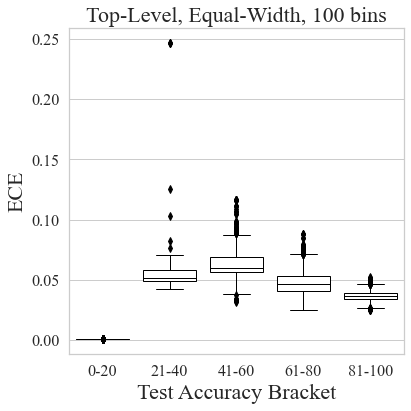

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = []
for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
    plot_data.append(ece_df.loc[ece_df['accuracy_bracket'] == bracket, '100_bins'])

# Creating the box plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.boxplot(data=plot_data,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set font sizes

# Set plot title and axis labels
plt.title("Top-Level, Equal-Width, 100 bins", fontsize=title_font_size)
plt.xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
plt.ylabel("ECE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
plt.xticks(range(len(['0-20', '21-40', '41-60', '61-80', '81-100'])), ['0-20', '21-40', '41-60', '61-80', '81-100'],fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.savefig("fig/cifar10_100_bins_TopLevelEWBCE_on_different_Accuracy.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

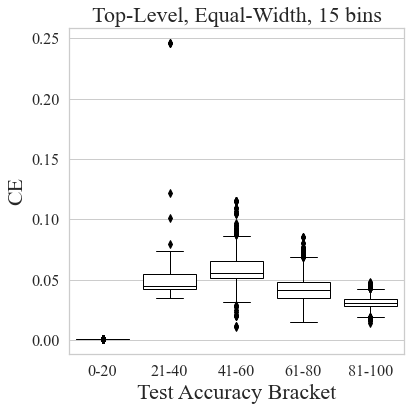

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = []
for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
    plot_data.append(ece_df.loc[ece_df['accuracy_bracket'] == bracket, '15_bins'])

# Creating the box plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.boxplot(data=plot_data,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
plt.title("Top-Level, Equal-Width, 15 bins", fontsize=title_font_size)
plt.xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
plt.ylabel("CE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
plt.xticks(range(len(['0-20', '21-40', '41-60', '61-80', '81-100'])), ['0-20', '21-40', '41-60', '61-80', '81-100'],fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.savefig("fig/cifar10_15_bins_TopLevelEWBCE_on_different_Accuracy.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

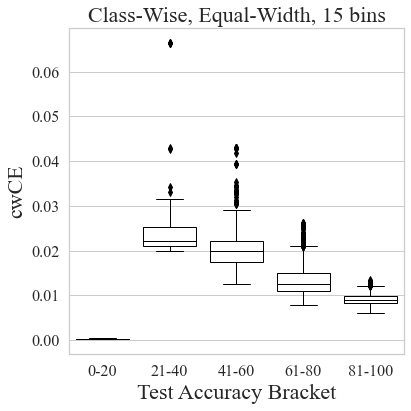

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is your dataframe

# Create a new column to categorize test accuracy into 5 brackets
def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

cwECE_df['accuracy_bracket'] = cwECE_df['test-accuracy'].apply(categorize_test_accuracy)

import seaborn as sns
import matplotlib.pyplot as plt

plot_data = []
for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
    plot_data.append(cwECE_df.loc[cwECE_df['accuracy_bracket'] == bracket, '15_bins'])

# Creating the box plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.boxplot(data=plot_data,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

plt.title("Class-Wise, Equal-Width, 15 bins", fontsize=title_font_size)
plt.xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
plt.ylabel("cwCE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
plt.xticks(range(len(['0-20', '21-40', '41-60', '61-80', '81-100'])), ['0-20', '21-40', '41-60', '61-80', '81-100'],fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.savefig("fig/cifar10_15_bins_cwEWBCE_on_different_Accuracy.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

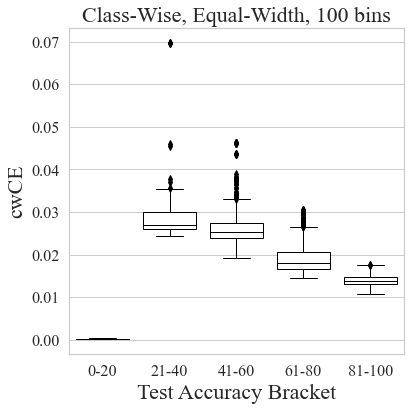

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is your dataframe

# Create a new column to categorize test accuracy into 5 brackets
def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

cwECE_df['accuracy_bracket'] = cwECE_df['test-accuracy'].apply(categorize_test_accuracy)

import seaborn as sns
import matplotlib.pyplot as plt

plot_data = []
for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
    plot_data.append(cwECE_df.loc[cwECE_df['accuracy_bracket'] == bracket, '100_bins'])

# Creating the box plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.boxplot(data=plot_data,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

plt.title("Class-Wise, Equal-Width, 100 bins", fontsize=title_font_size)
plt.xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
plt.ylabel("cwCE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
plt.xticks(range(len(['0-20', '21-40', '41-60', '61-80', '81-100'])), ['0-20', '21-40', '41-60', '61-80', '81-100'],fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.savefig("fig/cifar10_100_bins_cwEWBCE_on_different_Accuracy.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

In [80]:
import pandas as pd
df = pd.read_csv('final_results/sss/cifar10_sss.csv')

In [81]:
df['arch_sum'] = df['arch'].apply(lambda x: sum(int(i) for i in x.split(':')))

In [12]:


# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecesss_df = pd.DataFrame(columns=['ECE_15','Accuracy','arch'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}

    esult_15 = next((d['result'] for d in ecepost_data if d['n_bins'] == 15), None)*100

    bins_data['ECE_15'] = esult_15
    bins_data['Accuracy'] = row['info']*100
    bins_data['arch'] = row['arch_sum']
    
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecesss_df = pd.concat([ecesss_df, data_to_append], ignore_index=True)

plotpost_df = ecesss_df


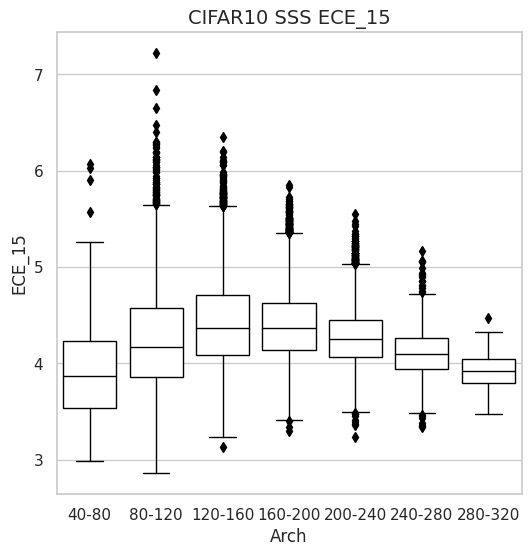

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and the labels for the bins
bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# Add a new column 'arch_bins' to your DataFrame based on 'arch'
plotpost_df['arch_bins'] = pd.cut(plotpost_df['arch'], bins=bins, labels=labels, include_lowest=True)

# Set the plot style and create a new figure
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# Create a box plot
sns.boxplot(x='arch_bins', y='ECE_15', data=plotpost_df,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the plot title and axis labels
plt.title("CIFAR10 SSS ECE_15", fontsize=14)
plt.xlabel("Arch", fontsize=12)
plt.ylabel("ECE_15", fontsize=12)

# Show the plot
plt.show()

In [83]:
import pandas as pd
df = pd.read_csv('final_results/sss/cifar10_sss.csv')

df['arch_sum'] = df['arch'].apply(lambda x: sum(int(i) for i in x.split(':')))

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecesss_df = pd.DataFrame(columns=['ECE_15','Accuracy','arch'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}

    esult_15 = next((d['result'] for d in ecepost_data if d['n_bins'] == 15), None)*100

    bins_data['ECE_15'] = esult_15
    bins_data['Accuracy'] = row['info']*100
    bins_data['arch'] = row['arch_sum']
    
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecesss_df = pd.concat([ecesss_df, data_to_append], ignore_index=True)

plotpost_df = ecesss_df



filtered_df = plotpost_df[(plotpost_df['Accuracy'] >= 90) & (plotpost_df['Accuracy'] <= 92)]

/tmp/ipykernel_1336107/4088481689.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['arch_bins'] = pd.cut(filtered_df['arch'], bins=bins, labels=labels, include_lowest=True)


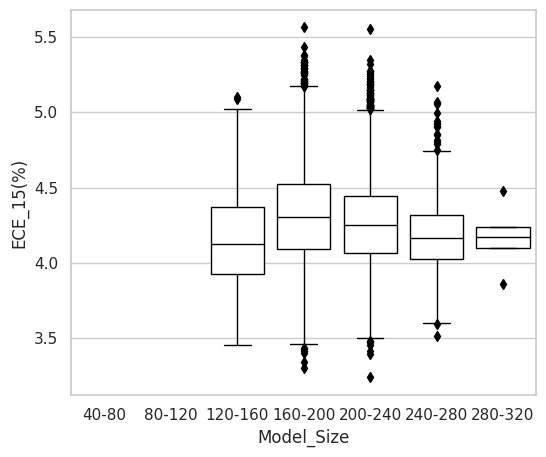

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and the labels for the bins
bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# Add a new column 'arch_bins' to your DataFrame based on 'arch'
filtered_df['arch_bins'] = pd.cut(filtered_df['arch'], bins=bins, labels=labels, include_lowest=True)

# Set the plot style and create a new figure
sns.set(style="whitegrid")
plt.figure(figsize=(6, 5))

# Create a box plot
sns.boxplot(x='arch_bins', y='ECE_15', data=filtered_df,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the plot title and axis labels
# plt.title("CIFAR10 SSS ECE_15", fontsize=14)
plt.xlabel("Model_Size", fontsize=12)
plt.ylabel("ECE_15(%)", fontsize=12)

# Show the plot

plt.savefig("fig/rebuttal_4.7.pdf", dpi=300, format='pdf', bbox_inches='tight')

plt.show()

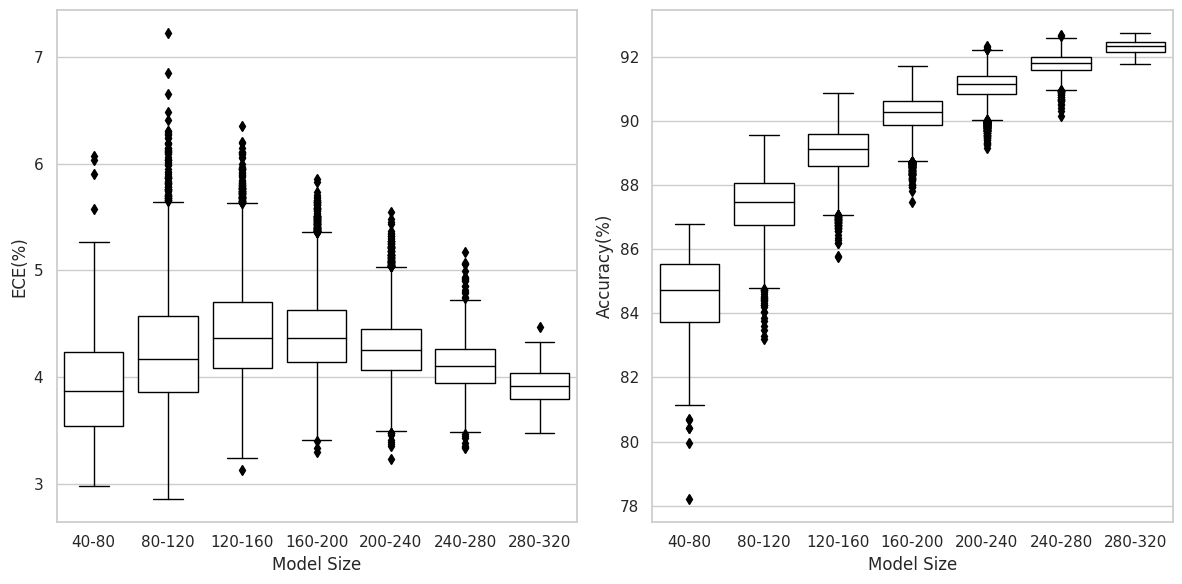

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16

# Define the bins and the labels for the bins
bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# Add a new column 'arch_bins' to your DataFrame based on 'arch'
plotpost_df['arch_bins'] = pd.cut(plotpost_df['arch'], bins=bins, labels=labels, include_lowest=True)

# Set the plot style
sns.set(style="whitegrid")

# Create a new figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create the first boxplot (arch_bins vs ECE_15)
sns.boxplot(x='arch_bins', y='ECE_15', data=plotpost_df, ax=axs[0],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the title and axis labels for the first plot
axs[0].set_xlabel("Model Size", fontsize=12)
axs[0].set_ylabel("ECE(%)", fontsize=12)

# Create the second boxplot (arch_bins vs Accuracy)
sns.boxplot(x='arch_bins', y='Accuracy', data=plotpost_df, ax=axs[1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the title and axis labels for the second plot
axs[1].set_xlabel("Model Size", fontsize=12)
axs[1].set_ylabel("Accuracy(%)", fontsize=12)

# fig.suptitle('CIFAR10 SSS', fontsize=20)
# Adjust the space between the plots
plt.tight_layout()
plt.savefig("fig/cifar10_sss.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plots
plt.show()

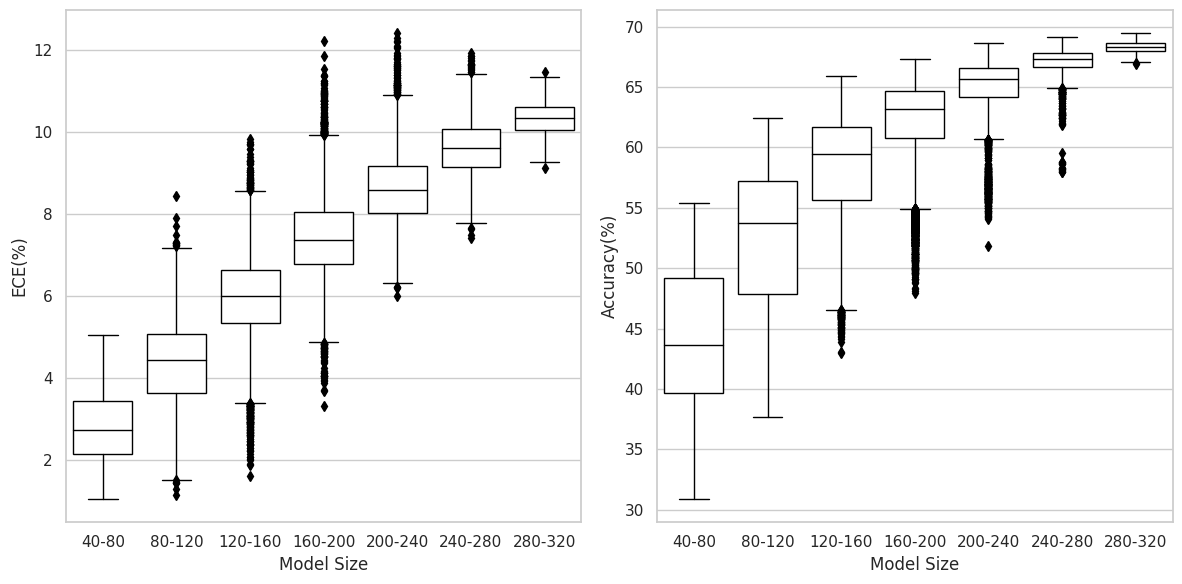

In [11]:
import pandas as pd
df = pd.read_csv('final_results/sss/cifar100_sss.csv')


df['arch_sum'] = df['arch'].apply(lambda x: sum(int(i) for i in x.split(':')))

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecesss_df = pd.DataFrame(columns=['ECE_15','Accuracy','arch'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}

    esult_15 = next((d['result'] for d in ecepost_data if d['n_bins'] == 15), None)*100

    bins_data['ECE_15'] = esult_15
    bins_data['Accuracy'] = row['info']*100
    bins_data['arch'] = row['arch_sum']
    
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecesss_df = pd.concat([ecesss_df, data_to_append], ignore_index=True)

plotpost_df = ecesss_df

# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define the bins and the labels for the bins
# bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
# labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# # Add a new column 'arch_bins' to your DataFrame based on 'arch'
# plotpost_df['arch_bins'] = pd.cut(plotpost_df['arch'], bins=bins, labels=labels, include_lowest=True)

# # Set the plot style and create a new figure
# sns.set(style="whitegrid")
# plt.figure(figsize=(6, 6))

# # Create a box plot
# sns.boxplot(x='arch_bins', y='ECE_15', data=plotpost_df,
#             boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
#             capprops=dict(color='black', linewidth=1),
#             whiskerprops=dict(color='black', linewidth=1),
#             medianprops=dict(color='black', linewidth=1),
#             flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# # Set the plot title and axis labels
# plt.title("CIFAR100 SSS ECE_15", fontsize=14)
# plt.xlabel("Arch", fontsize=12)
# plt.ylabel("ECE_15", fontsize=12)

# # Show the plot
# plt.show()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and the labels for the bins
bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# Add a new column 'arch_bins' to your DataFrame based on 'arch'
plotpost_df['arch_bins'] = pd.cut(plotpost_df['arch'], bins=bins, labels=labels, include_lowest=True)

# Set the plot style
sns.set(style="whitegrid")

# Create a new figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create the first boxplot (arch_bins vs ECE_15)
sns.boxplot(x='arch_bins', y='ECE_15', data=plotpost_df, ax=axs[0],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the title and axis labels for the first plot

axs[0].set_xlabel("Model Size", fontsize=12)
axs[0].set_ylabel("ECE(%)", fontsize=12)

# Create the second boxplot (arch_bins vs Accuracy)
sns.boxplot(x='arch_bins', y='Accuracy', data=plotpost_df, ax=axs[1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the title and axis labels for the second plot

axs[1].set_xlabel("Model Size", fontsize=12)
axs[1].set_ylabel("Accuracy(%)", fontsize=12)

# Adjust the space between the plots


plt.tight_layout()
plt.savefig("fig/cifar100_sss.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plots
plt.show()

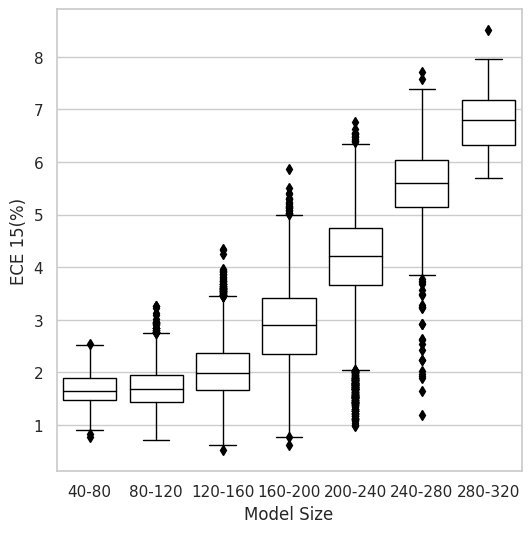

In [241]:
import pandas as pd
df = pd.read_csv('final_results/sss/imagenet_sss.csv')


df['arch_sum'] = df['arch'].apply(lambda x: sum(int(i) for i in x.split(':')))



# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecesss_df = pd.DataFrame(columns=['ECE_15','Accuracy','arch'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}

    esult_15 = next((d['result'] for d in ecepost_data if d['n_bins'] == 15), None)*100

    bins_data['ECE_15'] = esult_15
    bins_data['Accuracy'] = row['info']*100
    bins_data['arch'] = row['arch_sum']
    
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecesss_df = pd.concat([ecesss_df, data_to_append], ignore_index=True)

plotpost_df = ecesss_df




import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and the labels for the bins
bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# Add a new column 'arch_bins' to your DataFrame based on 'arch'
plotpost_df['arch_bins'] = pd.cut(plotpost_df['arch'], bins=bins, labels=labels, include_lowest=True)

# Set the plot style and create a new figure
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# Create a box plot
sns.boxplot(x='arch_bins', y='ECE_15', data=plotpost_df,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the plot title and axis labels
# plt.title("ImageNet SSS ECE_15", fontsize=14)
plt.xlabel("Model Size", fontsize=12)
plt.ylabel("ECE 15(%)", fontsize=12)

# Show the plot
# plt.show()


# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define the bins and the labels for the bins
# bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
# labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# # Add a new column 'arch_bins' to your DataFrame based on 'arch'
# plotpost_df['arch_bins'] = pd.cut(plotpost_df['arch'], bins=bins, labels=labels, include_lowest=True)

# # Set the plot style
# sns.set(style="whitegrid")

# # Create a new figure with 2 subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Create the first boxplot (arch_bins vs ECE_15)
# sns.boxplot(x='arch_bins', y='ECE_15', data=plotpost_df, ax=axs[0],
#             boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
#             capprops=dict(color='black', linewidth=1),
#             whiskerprops=dict(color='black', linewidth=1),
#             medianprops=dict(color='black', linewidth=1),
#             flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# # Set the title and axis labels for the first plot

# axs[0].set_xlabel("Model Size", fontsize=12)
# axs[0].set_ylabel("ECE 15(%)", fontsize=12)

# # Create the second boxplot (arch_bins vs Accuracy)
# sns.boxplot(x='arch_bins', y='Accuracy', data=plotpost_df, ax=axs[1],
#             boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
#             capprops=dict(color='black', linewidth=1),
#             whiskerprops=dict(color='black', linewidth=1),
#             medianprops=dict(color='black', linewidth=1),
#             flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# # Set the title and axis labels for the second plot

# axs[1].set_xlabel("Model Size", fontsize=12)
# axs[1].set_ylabel("Accuracy(%)", fontsize=12)
# # fig.suptitle('ImageNet16-120 SSS', fontsize=20)
# # Adjust the space between the plots
# plt.tight_layout()

plt.savefig("fig/imagenet_sss_singleplot.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plots
plt.show()

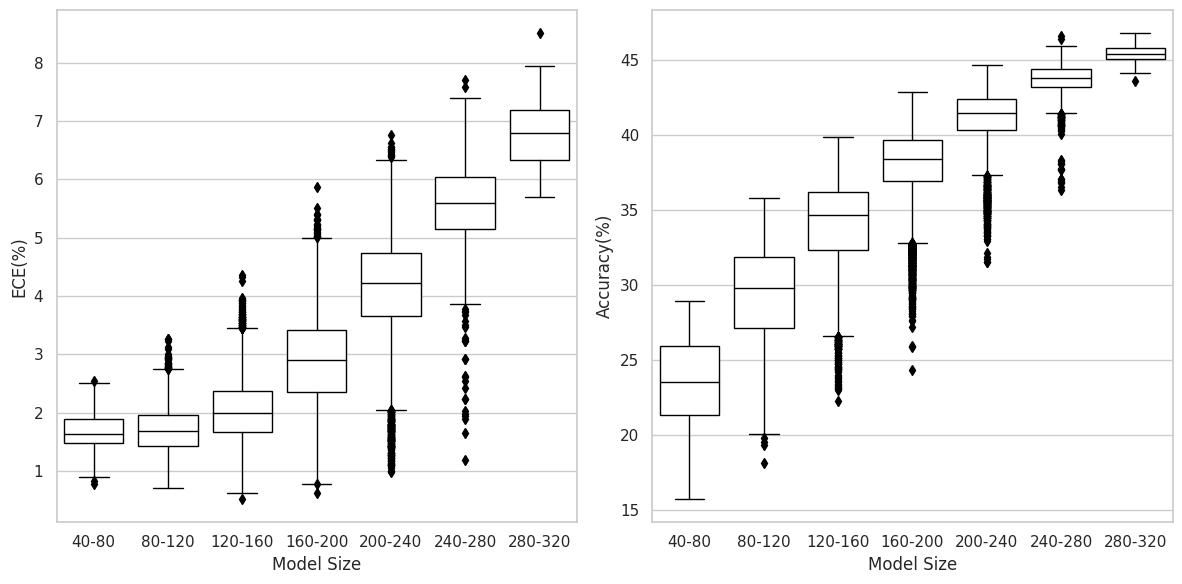

In [10]:
import pandas as pd
df = pd.read_csv('final_results/sss/imagenet_sss.csv')


df['arch_sum'] = df['arch'].apply(lambda x: sum(int(i) for i in x.split(':')))



# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecesss_df = pd.DataFrame(columns=['ECE_15','Accuracy','arch'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}

    esult_15 = next((d['result'] for d in ecepost_data if d['n_bins'] == 15), None)*100

    bins_data['ECE_15'] = esult_15
    bins_data['Accuracy'] = row['info']*100
    bins_data['arch'] = row['arch_sum']
    
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecesss_df = pd.concat([ecesss_df, data_to_append], ignore_index=True)

plotpost_df = ecesss_df




# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define the bins and the labels for the bins
# bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
# labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# # Add a new column 'arch_bins' to your DataFrame based on 'arch'
# plotpost_df['arch_bins'] = pd.cut(plotpost_df['arch'], bins=bins, labels=labels, include_lowest=True)

# # Set the plot style and create a new figure
# sns.set(style="whitegrid")
# plt.figure(figsize=(6, 6))

# # Create a box plot
# sns.boxplot(x='arch_bins', y='ECE_15', data=plotpost_df,
#             boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
#             capprops=dict(color='black', linewidth=1),
#             whiskerprops=dict(color='black', linewidth=1),
#             medianprops=dict(color='black', linewidth=1),
#             flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# # Set the plot title and axis labels
# plt.title("ImageNet SSS ECE_15", fontsize=14)
# plt.xlabel("Arch", fontsize=12)
# plt.ylabel("ECE_15", fontsize=12)

# # Show the plot
# plt.show()


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and the labels for the bins
bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# Add a new column 'arch_bins' to your DataFrame based on 'arch'
plotpost_df['arch_bins'] = pd.cut(plotpost_df['arch'], bins=bins, labels=labels, include_lowest=True)

# Set the plot style
sns.set(style="whitegrid")

# Create a new figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create the first boxplot (arch_bins vs ECE_15)
sns.boxplot(x='arch_bins', y='ECE_15', data=plotpost_df, ax=axs[0],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the title and axis labels for the first plot

axs[0].set_xlabel("Model Size", fontsize=12)
axs[0].set_ylabel("ECE(%)", fontsize=12)

# Create the second boxplot (arch_bins vs Accuracy)
sns.boxplot(x='arch_bins', y='Accuracy', data=plotpost_df, ax=axs[1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the title and axis labels for the second plot

axs[1].set_xlabel("Model Size", fontsize=12)
axs[1].set_ylabel("Accuracy(%)", fontsize=12)
# fig.suptitle('ImageNet16-120 SSS', fontsize=20)
# Adjust the space between the plots
plt.tight_layout()

plt.savefig("fig/imagenet_sss.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plots
plt.show()

In [1]:
import pandas as pd
df = pd.read_csv('public_results/imagenet_sss.csv')


df['arch_sum'] = df['arch'].apply(lambda x: sum(int(i) for i in x.split(':')))

In [2]:
df.columns

Index(['config', 'acc', 'dataset', 'arch', 'ECE_5', 'ECE_10', 'ECE_15',
       'ECE_20', 'ECE_25', 'ECE_50', 'ECE_100', 'ECE_200', 'ECE_500',
       'ECE_em_5', 'ECE_em_10', 'ECE_em_15', 'ECE_em_20', 'ECE_em_25',
       'ECE_em_50', 'ECE_em_100', 'ECE_em_200', 'ECE_em_500', 'cwCE_5',
       'cwCE_10', 'cwCE_15', 'cwCE_20', 'cwCE_25', 'cwCE_50', 'cwCE_100',
       'cwCE_200', 'cwCE_500', 'cwCE_em_5', 'cwCE_em_10', 'cwCE_em_15',
       'cwCE_em_20', 'cwCE_em_25', 'cwCE_em_50', 'cwCE_em_100', 'cwCE_em_200',
       'cwCE_em_500', 'arch_sum'],
      dtype='object')

In [4]:
plot_df = df[['acc','cwCE_em_15','arch_sum']]

/tmp/ipykernel_2482332/2279043251.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['arch_bins'] = pd.cut(plot_df['arch_sum'], bins=bins, labels=labels, include_lowest=True)


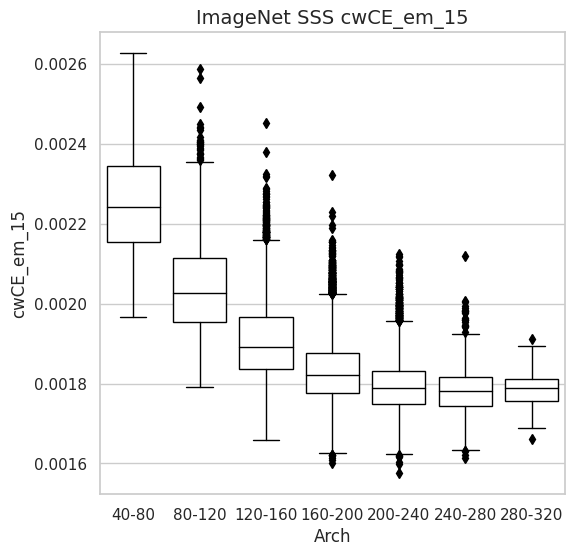

In [6]:





import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and the labels for the bins
bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# Add a new column 'arch_bins' to your DataFrame based on 'arch'
plot_df['arch_bins'] = pd.cut(plot_df['arch_sum'], bins=bins, labels=labels, include_lowest=True)

# Set the plot style and create a new figure
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# Create a box plot
sns.boxplot(x='arch_bins', y='cwCE_em_15', data=plot_df,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the plot title and axis labels
plt.title("ImageNet SSS cwCE_em_15", fontsize=14)
plt.xlabel("Arch", fontsize=12)
plt.ylabel("cwCE_em_15", fontsize=12)

# Show the plot
plt.show()

/tmp/ipykernel_2482332/4202237141.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['arch_bins'] = pd.cut(plot_df['arch_sum'], bins=bins, labels=labels, include_lowest=True)


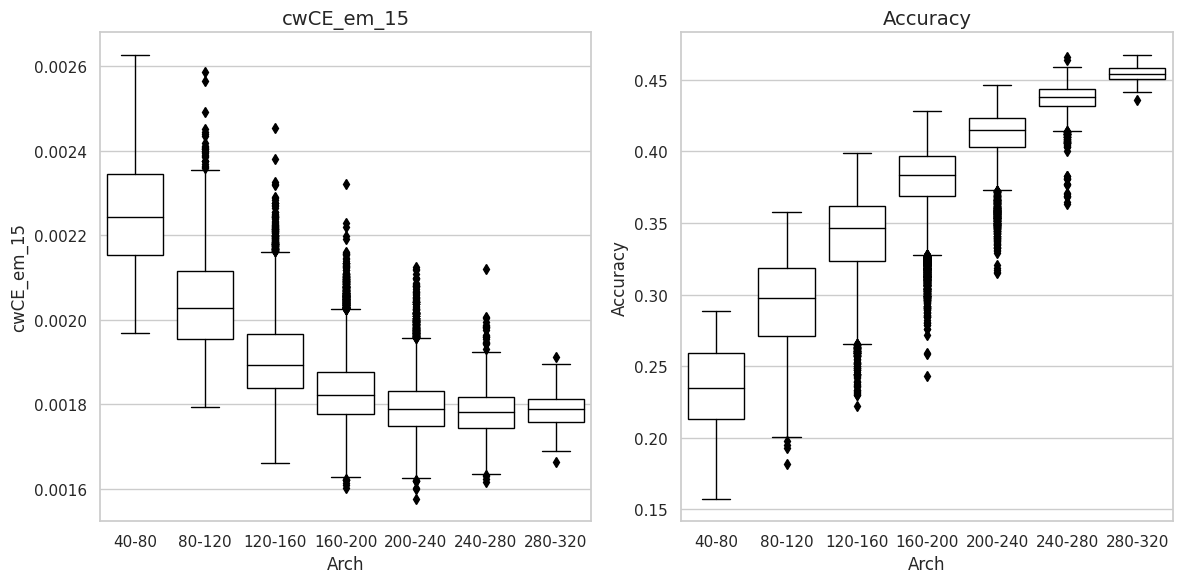

In [10]:

title_font_size = 22
axis_label_font_size = 18
tick_label_font_size = 16

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and the labels for the bins
bins = np.arange(40, 360, 40)  # this creates an array [40, 80, 120, ..., 320]
labels = ['40-80', '80-120', '120-160', '160-200', '200-240', '240-280', '280-320']

# Add a new column 'arch_bins' to your DataFrame based on 'arch'
plot_df['arch_bins'] = pd.cut(plot_df['arch_sum'], bins=bins, labels=labels, include_lowest=True)

# Set the plot style
sns.set(style="whitegrid")

# Create a new figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create the first boxplot (arch_bins vs ECE_15)
sns.boxplot(x='arch_bins', y='cwCE_em_15', data=plot_df, ax=axs[0],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the title and axis labels for the first plot
axs[0].set_title("cwCE_em_15", fontsize=14)
axs[0].set_xlabel("Arch", fontsize=12)
axs[0].set_ylabel("cwCE_em_15", fontsize=12)

# Create the second boxplot (arch_bins vs Accuracy)
sns.boxplot(x='arch_bins', y='acc', data=plot_df, ax=axs[1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set the title and axis labels for the second plot
axs[1].set_title("Accuracy", fontsize=14)
axs[1].set_xlabel("Arch", fontsize=12)
axs[1].set_ylabel("Accuracy", fontsize=12)

# Adjust the space between the plots
plt.tight_layout()

# Show the plots
plt.show()

In [215]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman


df_imagenet = pd.read_csv('./public_results/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./public_results/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./public_results/cifar100_sss.csv')

In [217]:

df_cifar10['arch_sum'] = df_cifar10['arch'].apply(lambda x: sum(int(i) for i in x.split(':')))

In [ ]:
sns.color_palette("flare", len())

In [222]:
plot_df = df_cifar10[['acc','ECE_15','arch_sum']]

In [223]:
plot_df['ECE_15'] = plot_df['ECE_15']*100
plot_df['acc'] = plot_df['acc']*100

/tmp/ipykernel_529477/3622285636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['ECE_15'] = plot_df['ECE_15']*100
/tmp/ipykernel_529477/3622285636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['acc'] = plot_df['acc']*100


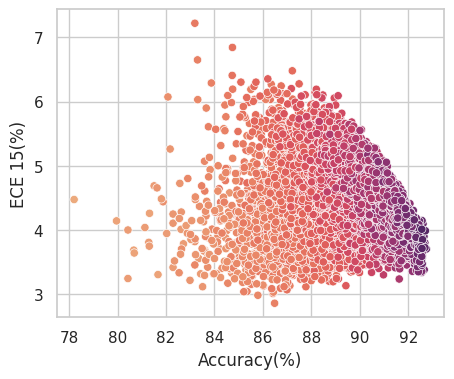

<Figure size 640x480 with 0 Axes>

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_cifar10 is your DataFrame and it has been imported correctly
plt.figure(figsize=(5, 4))

# Create a color palette
palette = sns.color_palette("flare", len(plot_df['arch_sum'].unique()))

# Plot the scatterplot
sns.scatterplot(data=plot_df, x='acc', y='ECE_15', hue='arch_sum', palette=palette, legend=False)

# plt.title('Scatter Plot of ECE_15 vs Accuracy')
plt.xlabel('Accuracy(%)')
plt.ylabel('ECE 15(%)')
plt.show()

plt.savefig("fig/cifar10_ece15_scatterplot.pdf", dpi=300, format='pdf', bbox_inches='tight')

In [228]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman


df_imagenet = pd.read_csv('./public_results/imagenet_sss.csv')
df_cifar10 = pd.read_csv('./public_results/cifar10_sss.csv')
df_cifar100 = pd.read_csv('./public_results/cifar100_sss.csv')

In [229]:
df_imagenet_post = pd.read_csv('./public_results/imagenet_sss_post.csv')
df_cifar10_post = pd.read_csv('./public_results/cifar10_sss_post.csv')
df_cifar100_post = pd.read_csv('./public_results/cifar100_sss_post.csv')

In [233]:
list_arch = ['8:8:8:8:8','16:16:16:16:16','24:24:24:24:24','32:32:32:32:32','40:40:40:40:40','48:48:48:48:48',
             '56:56:56:56:56','64:64:64:64:64']

arch_to_dot_size = {'8:8:8:8:8': 100, '16:16:16:16:16': 200, '24:24:24:24:24': 300, 
                    '32:32:32:32:32': 400, '40:40:40:40:40': 500, '48:48:48:48:48': 600, 
                    '56:56:56:56:56': 700, '64:64:64:64:64': 800}

df_imagenet['dot_size'] = df_imagenet['arch'].map(arch_to_dot_size)
df_cifar10['dot_size'] = df_cifar10['arch'].map(arch_to_dot_size)
df_cifar100['dot_size'] = df_cifar100['arch'].map(arch_to_dot_size)

df_imagenet_post['dot_size'] = df_imagenet_post['arch'].map(arch_to_dot_size)
df_cifar10_post['dot_size'] = df_cifar10_post['arch'].map(arch_to_dot_size)
df_cifar100_post['dot_size'] = df_cifar100_post['arch'].map(arch_to_dot_size)

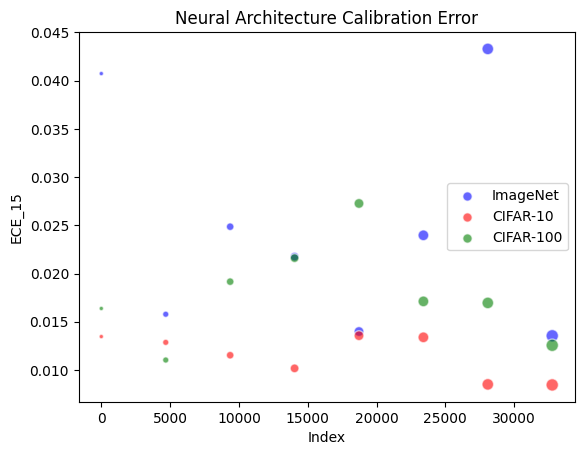

In [16]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Scatter plot for each dataframe
ax.scatter(df_imagenet.index, df_imagenet['ECE_15'], s=df_imagenet['dot_size'], c='blue', label='ImageNet', alpha=0.6, edgecolors='w')
ax.scatter(df_cifar10.index, df_cifar10['ECE_15'], s=df_cifar10['dot_size'], c='red', label='CIFAR-10', alpha=0.6, edgecolors='w')
ax.scatter(df_cifar100.index, df_cifar100['ECE_15'], s=df_cifar100['dot_size'], c='green', label='CIFAR-100', alpha=0.6, edgecolors='w')

# Set plot title and labels
ax.set_title('Neural Architecture Calibration Error')
ax.set_xlabel('Index')
ax.set_ylabel('ECE_15')

# Add a legend
ax.legend()

# Show the plot
plt.show()

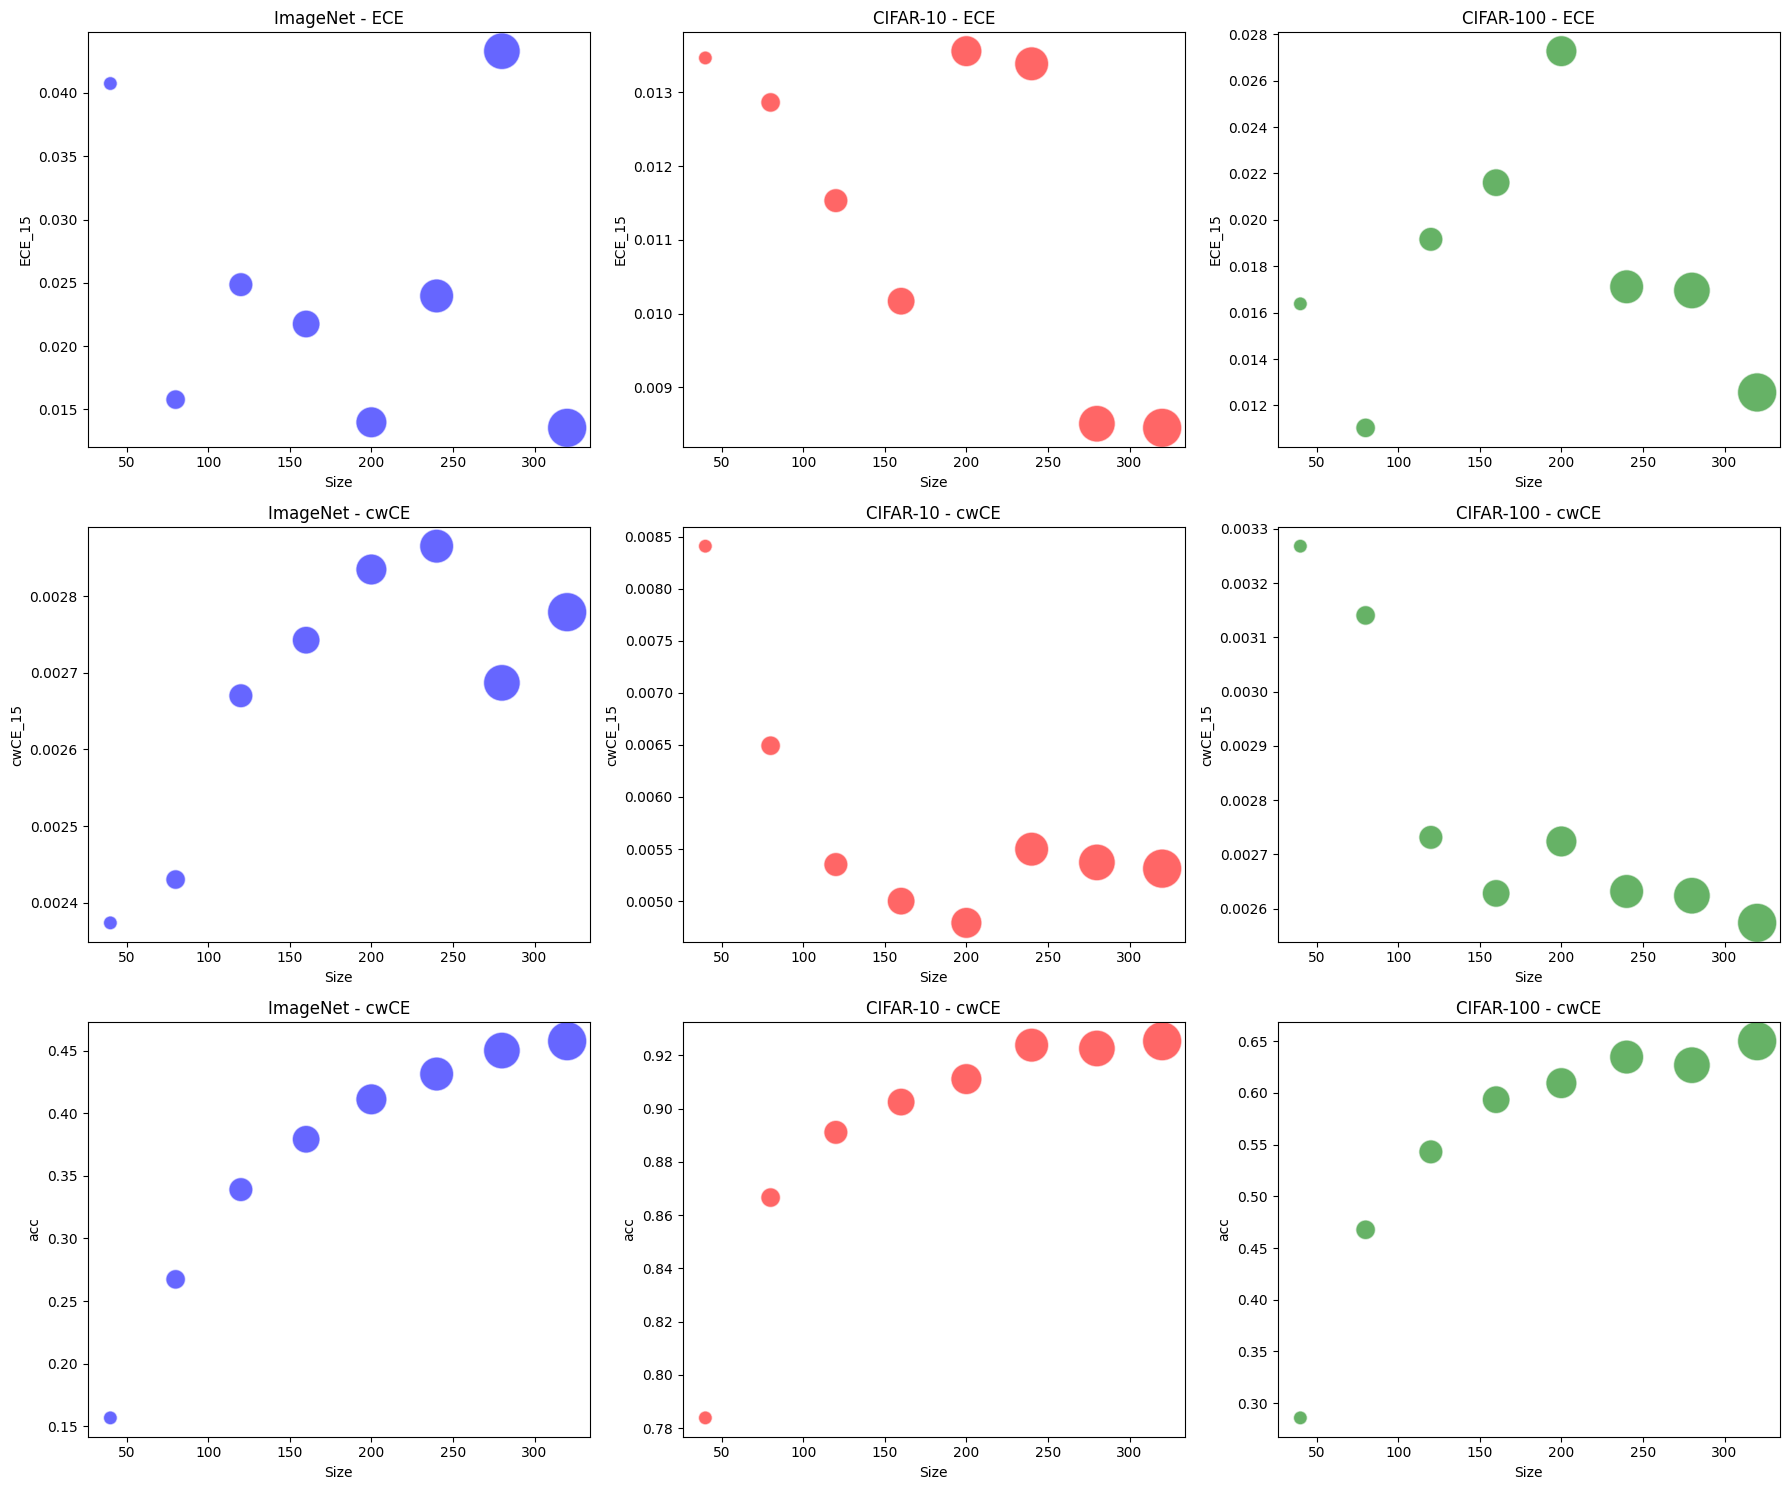

In [20]:
import matplotlib.pyplot as plt

# Create a new column for the size of the architecture
def arch_to_size(arch):
    return sum(int(x) for x in arch.split(':'))

df_imagenet['size'] = df_imagenet['arch'].apply(arch_to_size)
df_cifar10['size'] = df_cifar10['arch'].apply(arch_to_size)
df_cifar100['size'] = df_cifar100['arch'].apply(arch_to_size)

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

datasets = [(df_imagenet, 'ImageNet', 'blue'), 
            (df_cifar10, 'CIFAR-10', 'red'), 
            (df_cifar100, 'CIFAR-100', 'green')]

# Scatter plot for each dataframe
for i, (df, label, color) in enumerate(datasets):
    axs[0, i].scatter(df['size'], df['ECE_15'], s=df['dot_size'], c=color, label=label, alpha=0.6, edgecolors='w')
    axs[0, i].set_title(label + ' - ECE')
    axs[0, i].set_xlabel('Size')
    axs[0, i].set_ylabel('ECE_15')

for i, (df, label, color) in enumerate(datasets):
    axs[1, i].scatter(df['size'], df['cwCE_15'], s=df['dot_size'], c=color, label=label, alpha=0.6, edgecolors='w')
    axs[1, i].set_title(label + ' - cwCE')
    axs[1, i].set_xlabel('Size')
    axs[1, i].set_ylabel('cwCE_15')

for i, (df, label, color) in enumerate(datasets):
    axs[2, i].scatter(df['size'], df['acc'], s=df['dot_size'], c=color, label=label, alpha=0.6, edgecolors='w')
    axs[2, i].set_title(label + ' - cwCE')
    axs[2, i].set_xlabel('Size')
    axs[2, i].set_ylabel('acc')

# Adjust layout
plt.tight_layout()
plt.show()

/tmp/ipykernel_529477/1744171622.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, i].scatter(df['size'], df['ECE_15'], s=df['dot_size'], c=palette_orig[i], label=label, alpha=0.6, edgecolors='w')
/tmp/ipykernel_529477/1744171622.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, i].scatter(df_post['size'], df_post['ECE_15'], s=df_post['dot_size'], c=palette_post[i], label=label + ' Post', alpha=0.6, edgec

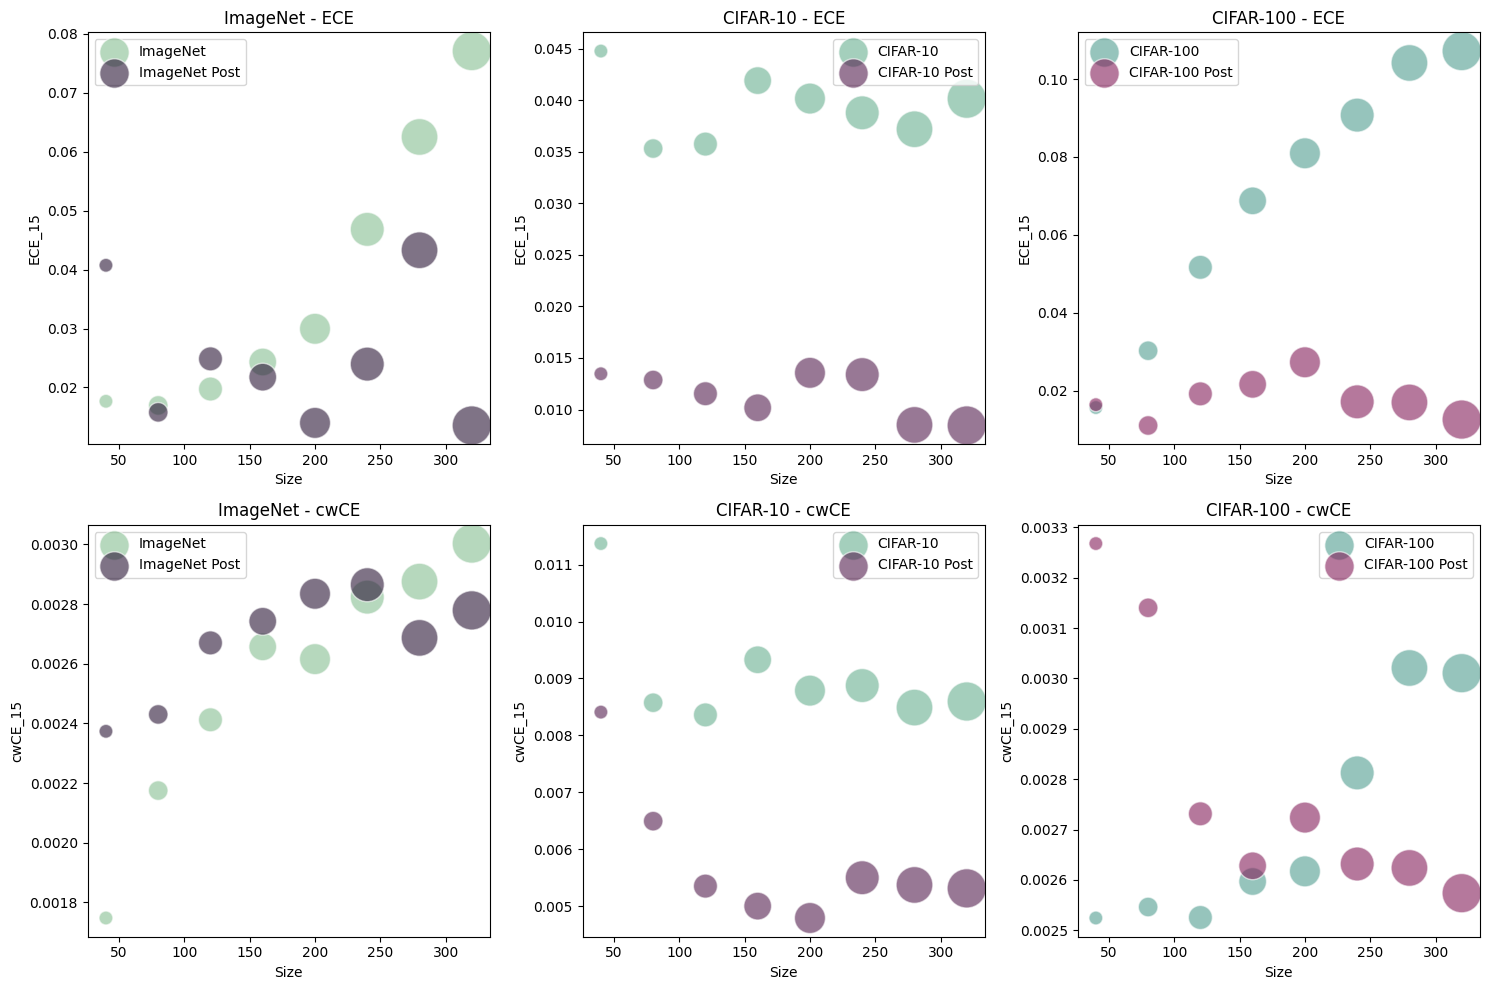

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for the size of the architecture
def arch_to_size(arch):
    return sum(int(x) for x in arch.split(':'))

# Apply size mapping to original datasets
df_imagenet['size'] = df_imagenet['arch'].apply(arch_to_size)
df_cifar10['size'] = df_cifar10['arch'].apply(arch_to_size)
df_cifar100['size'] = df_cifar100['arch'].apply(arch_to_size)

# Apply size mapping to post datasets
df_imagenet_post['size'] = df_imagenet_post['arch'].apply(arch_to_size)
df_cifar10_post['size'] = df_cifar10_post['arch'].apply(arch_to_size)
df_cifar100_post['size'] = df_cifar100_post['arch'].apply(arch_to_size)

# Define color palettes
palette_orig = sns.color_palette("crest", 8)
palette_post = sns.color_palette("rocket", 8)

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

datasets = [(df_imagenet, df_imagenet_post, 'ImageNet'), 
            (df_cifar10, df_cifar10_post, 'CIFAR-10'), 
            (df_cifar100, df_cifar100_post, 'CIFAR-100')]

# Scatter plot for each dataframe
for i, (df, df_post, label) in enumerate(datasets):
    axs[0, i].scatter(df['size'], df['ECE_15'], s=df['dot_size'], c=palette_orig[i], label=label, alpha=0.6, edgecolors='w')
    axs[0, i].scatter(df_post['size'], df_post['ECE_15'], s=df_post['dot_size'], c=palette_post[i], label=label + ' Post', alpha=0.6, edgecolors='w')
    axs[0, i].set_title(label + ' - ECE')
    axs[0, i].set_xlabel('Size')
    axs[0, i].set_ylabel('ECE_15')
    axs[0, i].legend()

for i, (df, df_post, label) in enumerate(datasets):
    axs[1, i].scatter(df['size'], df['cwCE_15'], s=df['dot_size'], c=palette_orig[i], label=label, alpha=0.6, edgecolors='w')
    axs[1, i].scatter(df_post['size'], df_post['cwCE_15'], s=df_post['dot_size'], c=palette_post[i], label=label + ' Post', alpha=0.6, edgecolors='w')
    axs[1, i].set_title(label + ' - cwCE')
    axs[1, i].set_xlabel('Size')
    axs[1, i].set_ylabel('cwCE_15')
    axs[1, i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

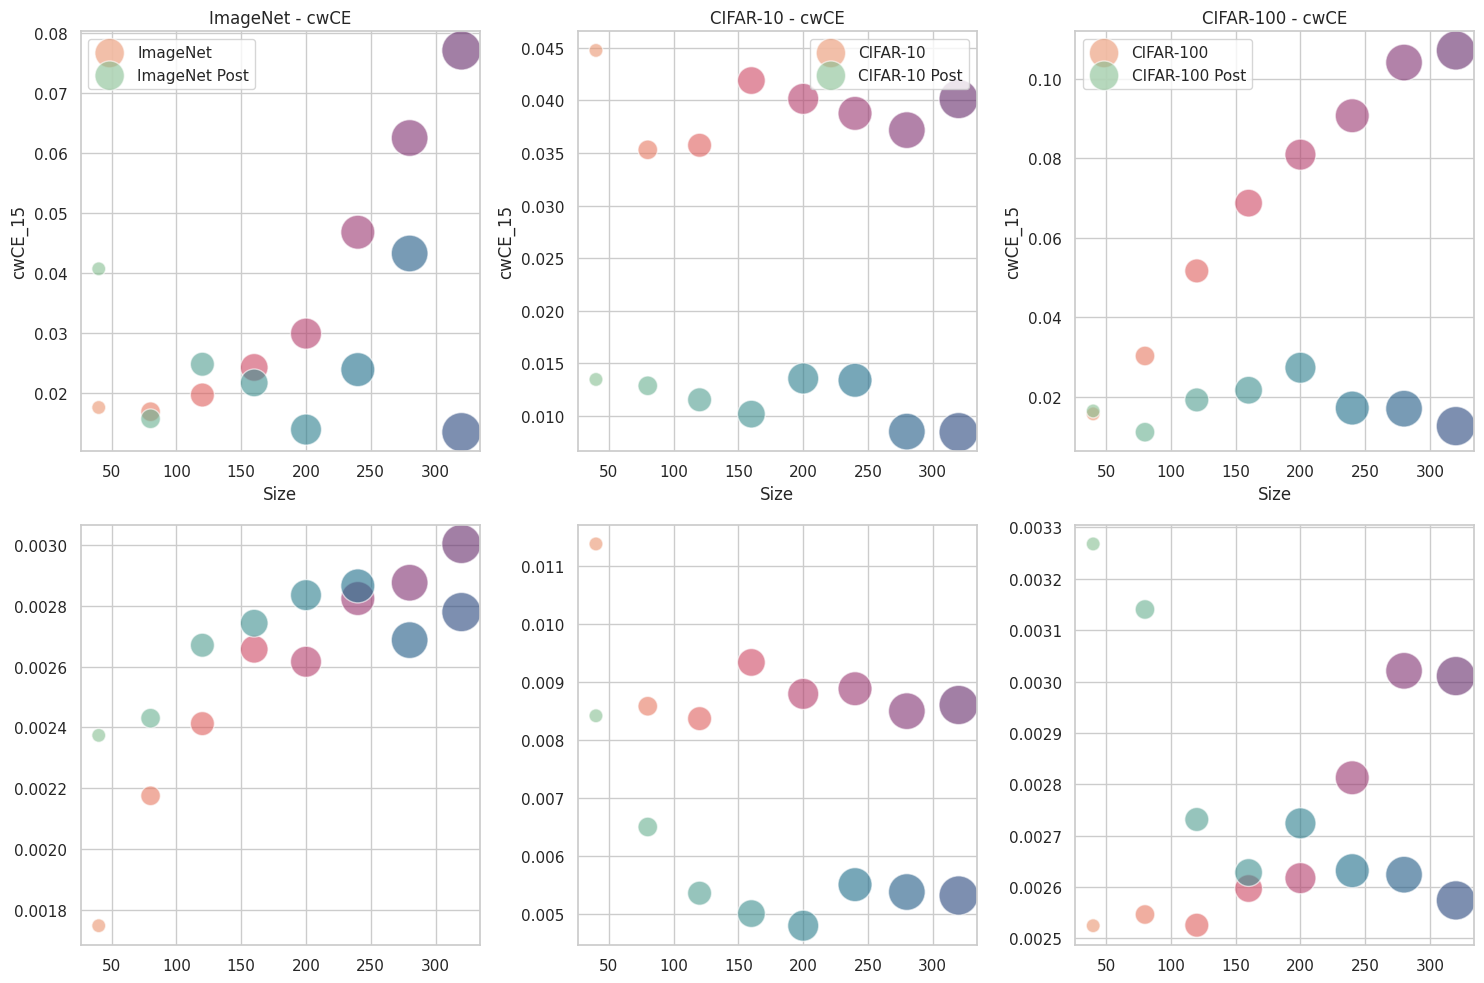

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Architecture list
list_arch = ['8:8:8:8:8','16:16:16:16:16','24:24:24:24:24','32:32:32:32:32','40:40:40:40:40',
             '48:48:48:48:48','56:56:56:56:56','64:64:64:64:64']

# Create a new column for the size of the architecture
def arch_to_size(arch):
    return sum(int(x) for x in arch.split(':'))

# Filter and apply size mapping to original datasets
df_imagenet = df_imagenet[df_imagenet['arch'].isin(list_arch)]
df_imagenet['size'] = df_imagenet['arch'].apply(arch_to_size)

df_cifar10 = df_cifar10[df_cifar10['arch'].isin(list_arch)]
df_cifar10['size'] = df_cifar10['arch'].apply(arch_to_size)

df_cifar100 = df_cifar100[df_cifar100['arch'].isin(list_arch)]
df_cifar100['size'] = df_cifar100['arch'].apply(arch_to_size)

# Filter and apply size mapping to post datasets
df_imagenet_post = df_imagenet_post[df_imagenet_post['arch'].isin(list_arch)]
df_imagenet_post['size'] = df_imagenet_post['arch'].apply(arch_to_size)

df_cifar10_post = df_cifar10_post[df_cifar10_post['arch'].isin(list_arch)]
df_cifar10_post['size'] = df_cifar10_post['arch'].apply(arch_to_size)

df_cifar100_post = df_cifar100_post[df_cifar100_post['arch'].isin(list_arch)]
df_cifar100_post['size'] = df_cifar100_post['arch'].apply(arch_to_size)

# Define color palettes
palette_orig = sns.color_palette("flare", len(list_arch))
palette_post = sns.color_palette("crest", len(list_arch))

# Define color mapping
def arch_to_color(arch):
    return list_arch.index(arch) if arch in list_arch else None

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

datasets = [(df_imagenet, df_imagenet_post, 'ImageNet'), 
            (df_cifar10, df_cifar10_post, 'CIFAR-10'), 
            (df_cifar100, df_cifar100_post, 'CIFAR-100')]

# Scatter plot for each dataframe
for i, (df, df_post, label) in enumerate(datasets):
    colors_orig = df['arch'].apply(arch_to_color).apply(lambda x: palette_orig[x])
    colors_post = df_post['arch'].apply(arch_to_color).apply(lambda x: palette_post[x])
    
    axs[0, i].scatter(df['size'], df['ECE_15'], s=df['dot_size'], c=colors_orig, label=label, alpha=0.6, edgecolors='w')
    axs[0, i].scatter(df_post['size'], df_post['ECE_15'], s=df_post['dot_size'], c=colors_post, label=label + ' Post', alpha=0.6, edgecolors='w')
    axs[0, i].set_title(label + ' - ECE')
    axs[0, i].set_xlabel('Size')
    axs[0, i].set_ylabel('ECE_15')
    axs[0, i].legend()

for i, (df, df_post, label) in enumerate(datasets):
    colors_orig = df['arch'].apply(arch_to_color).apply(lambda x: palette_orig[x])
    colors_post = df_post['arch'].apply(arch_to_color).apply(lambda x: palette_post[x])
    
    axs[1, i].scatter(df['size'], df['cwCE_15'], s=df['dot_size'], c=colors_orig, label=label, alpha=0.6, edgecolors='w')
    axs[1, i].scatter(df_post['size'], df_post['cwCE_15'], s=df_post['dot_size'], c=colors_post, label=label + ' Post', alpha=0.6, edgecolors='w')
    axs[0, i].set_title(label + ' - cwCE')
    axs[0, i].set_xlabel('Size')
    axs[0, i].set_ylabel('cwCE_15')
    axs[0, i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

/tmp/ipykernel_529477/379325405.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(df['size'], df['ECE_15'], s=df['dot_size'], c=palette_orig[5], alpha=0.9, edgecolors='w')
/tmp/ipykernel_529477/379325405.py:53: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(df_post['size'], df_post['ECE_15'], s=df_post['dot_size'], c=palette_post[5], alpha=0.9, edgecolors='w')


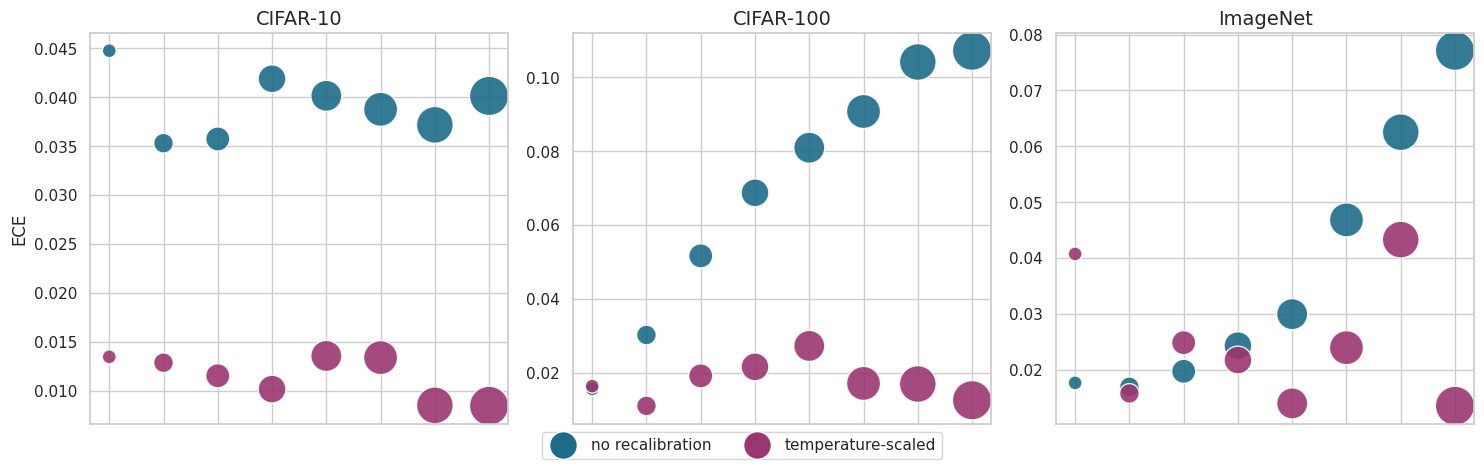

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Architecture list
list_arch = ['8:8:8:8:8','16:16:16:16:16','24:24:24:24:24','32:32:32:32:32','40:40:40:40:40',
             '48:48:48:48:48','56:56:56:56:56','64:64:64:64:64']

# Create a new column for the size of the architecture
def arch_to_size(arch):
    return sum(int(x) for x in arch.split(':'))

# Apply the architecture size and filter to the dataframes
df_imagenet = df_imagenet[df_imagenet['arch'].isin(list_arch)]
df_imagenet['size'] = df_imagenet['arch'].apply(arch_to_size)
df_imagenet_post = df_imagenet_post[df_imagenet_post['arch'].isin(list_arch)]
df_imagenet_post['size'] = df_imagenet_post['arch'].apply(arch_to_size)

df_cifar10 = df_cifar10[df_cifar10['arch'].isin(list_arch)]
df_cifar10['size'] = df_cifar10['arch'].apply(arch_to_size)
df_cifar10_post = df_cifar10_post[df_cifar10_post['arch'].isin(list_arch)]
df_cifar10_post['size'] = df_cifar10_post['arch'].apply(arch_to_size)

df_cifar100 = df_cifar100[df_cifar100['arch'].isin(list_arch)]
df_cifar100['size'] = df_cifar100['arch'].apply(arch_to_size)
df_cifar100_post = df_cifar100_post[df_cifar100_post['arch'].isin(list_arch)]
df_cifar100_post['size'] = df_cifar100_post['arch'].apply(arch_to_size)

# Define color palettes
palette_orig = sns.color_palette("crest", len(list_arch))
palette_post = sns.color_palette("flare", len(list_arch))

# Define color mapping
def arch_to_color(arch):
    return list_arch.index(arch) if arch in list_arch else None

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot for each dataframe
datasets = [
            (df_cifar10, df_cifar10_post, 'CIFAR-10'), 
            (df_cifar100, df_cifar100_post, 'CIFAR-100'),(df_imagenet, df_imagenet_post, 'ImageNet')]

size_to_label = {sum(int(x) for x in arch.split(':')): arch.split(':')[0] for arch in list_arch}


for i, (df, df_post, label) in enumerate(datasets):
    # colors_orig = df['arch'].apply(arch_to_color).apply(lambda x: palette_orig[x])
    # colors_post = df_post['arch'].apply(arch_to_color).apply(lambda x: palette_post[x])

    axs[i].scatter(df['size'], df['ECE_15'], s=df['dot_size'], c=palette_orig[5], alpha=0.9, edgecolors='w')
    axs[i].scatter(df_post['size'], df_post['ECE_15'], s=df_post['dot_size'], c=palette_post[5], alpha=0.9, edgecolors='w')
    axs[i].set_title(label, fontsize=14)
    axs[i].set_ylabel('ECE') if i == 0 else None
    axs[i].set_xticks(list(size_to_label.keys()))
    axs[i].set_xticklabels([])

# for i, (df, df_post, label) in enumerate(datasets):
#     # colors_orig = df['arch'].apply(arch_to_color).apply(lambda x: palette_orig[x])
#     # colors_post = df_post['arch'].apply(arch_to_color).apply(lambda x: palette_post[x])

#     axs[1, i].scatter(df['size'], df['cwCE_15'], s=df['dot_size'], c=palette_orig[5], alpha=0.9, edgecolors='w')
#     axs[1, i].scatter(df_post['size'], df_post['cwCE_15'], s=df_post['dot_size'], c=palette_post[5], alpha=0.9, edgecolors='w')
#     axs[1, i].set_xticks(list(size_to_label.keys()))
#     axs[1, i].set_xticklabels(list(size_to_label.values()))
#     axs[1, i].set_xlabel('Layer Width')
#     axs[1, i].set_ylabel('cwCE') if i == 0 else None

# Adjust layout
# Add legend
legend_labels = ['no recalibration', 'temperature-scaled']
legend_colors = [palette_orig[5], palette_post[5]]
legend_elements = [mlines.Line2D([], [], marker='o', color='w', label=label, markerfacecolor=color, markersize=20) for label, color in zip(legend_labels, legend_colors)]
legend = fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, 0.05))

# Adjust subplots layout
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("fig/sss_sizeplot.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Hide the last subplot


/tmp/ipykernel_529477/1914568403.py:55: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(df['acc']*100, df['ECE_15']*100, s=df['dot_size'], c=colors_orig, alpha=0.9, edgecolors='w')
/tmp/ipykernel_529477/1914568403.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(df_post['acc']*100, df_post['ECE_15']*100, s=df_post['dot_size'], c=colors_post, alpha=0.9, edgecolors='w')


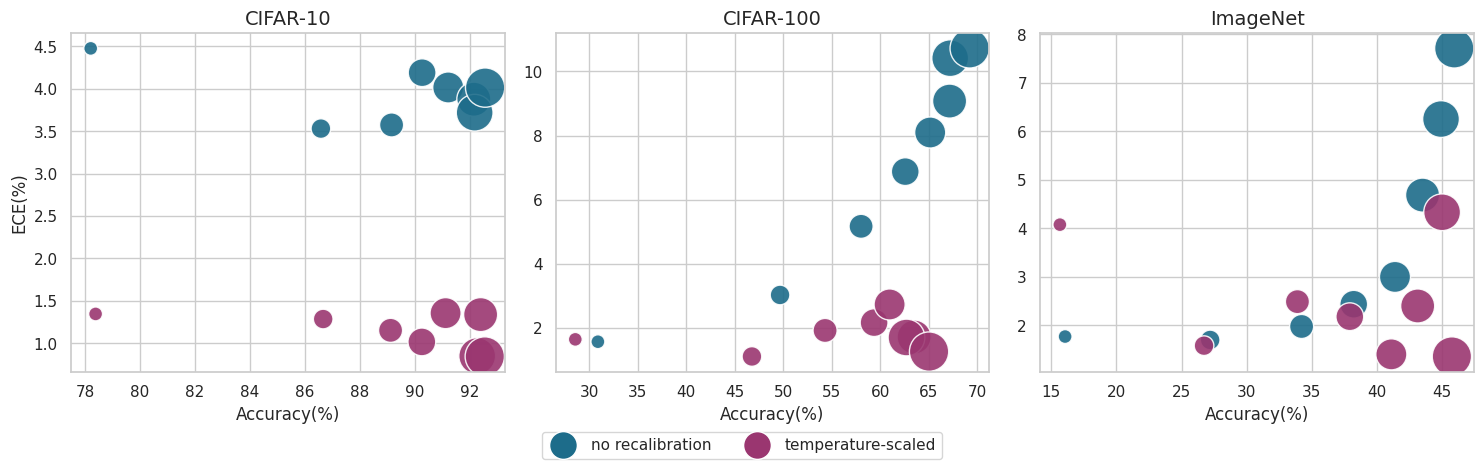

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Architecture list
list_arch = ['8:8:8:8:8','16:16:16:16:16','24:24:24:24:24','32:32:32:32:32','40:40:40:40:40',
             '48:48:48:48:48','56:56:56:56:56','64:64:64:64:64']

# Create a new column for the size of the architecture
def arch_to_size(arch):
    return sum(int(x) for x in arch.split(':'))

# Apply the architecture size and filter to the dataframes
df_imagenet = df_imagenet[df_imagenet['arch'].isin(list_arch)]
df_imagenet['size'] = df_imagenet['arch'].apply(arch_to_size)
df_imagenet_post = df_imagenet_post[df_imagenet_post['arch'].isin(list_arch)]
df_imagenet_post['size'] = df_imagenet_post['arch'].apply(arch_to_size)

df_cifar10 = df_cifar10[df_cifar10['arch'].isin(list_arch)]
df_cifar10['size'] = df_cifar10['arch'].apply(arch_to_size)
df_cifar10_post = df_cifar10_post[df_cifar10_post['arch'].isin(list_arch)]
df_cifar10_post['size'] = df_cifar10_post['arch'].apply(arch_to_size)

df_cifar100 = df_cifar100[df_cifar100['arch'].isin(list_arch)]
df_cifar100['size'] = df_cifar100['arch'].apply(arch_to_size)
df_cifar100_post = df_cifar100_post[df_cifar100_post['arch'].isin(list_arch)]
df_cifar100_post['size'] = df_cifar100_post['arch'].apply(arch_to_size)

# Define color palettes
palette_orig = sns.color_palette("crest", len(list_arch))
palette_post = sns.color_palette("flare", len(list_arch))

# Define color mapping
def arch_to_color(arch):
    return list_arch.index(arch) if arch in list_arch else None

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot for each dataframe
datasets = [
            (df_cifar10, df_cifar10_post, 'CIFAR-10'), 
            (df_cifar100, df_cifar100_post, 'CIFAR-100'),(df_imagenet, df_imagenet_post, 'ImageNet')]

size_to_label = {sum(int(x) for x in arch.split(':')): arch.split(':')[0] for arch in list_arch}


for i, (df, df_post, label) in enumerate(datasets):
    # colors_orig = df['arch'].apply(arch_to_color).apply(lambda x: palette_orig[x])
    # colors_post = df_post['arch'].apply(arch_to_color).apply(lambda x: palette_post[x])

    colors_orig = palette_orig[5]
    colors_post = palette_post[5]

    axs[i].scatter(df['acc']*100, df['ECE_15']*100, s=df['dot_size'], c=colors_orig, alpha=0.9, edgecolors='w')
    axs[i].scatter(df_post['acc']*100, df_post['ECE_15']*100, s=df_post['dot_size'], c=colors_post, alpha=0.9, edgecolors='w')
    axs[i].set_title(label, fontsize=14)
    axs[i].set_ylabel('ECE(%)') if i == 0 else None
    axs[i].set_xlabel('Accuracy(%)')

# for i, (df, df_post, label) in enumerate(datasets):
#     # colors_orig = df['arch'].apply(arch_to_color).apply(lambda x: palette_orig[x])
#     # colors_post = df_post['arch'].apply(arch_to_color).apply(lambda x: palette_post[x])

#     colors_orig = palette_orig[5]
#     colors_post = palette_post[5]


#     axs[1, i].scatter(df['acc']*100, df['cwCE_15']*100, s=df['dot_size'], c=colors_orig, alpha=0.9, edgecolors='w')
#     axs[1, i].scatter(df_post['acc']*100, df_post['cwCE_15']*100, s=df_post['dot_size'], c=colors_post, alpha=0.9, edgecolors='w')
#     axs[1, i].set_xlabel('Accuracy(%)')
#     axs[1, i].set_ylabel('cwCE(%)') if i == 0 else None

# Adjust layout
# Add legend
legend_labels = ['no recalibration', 'temperature-scaled']
legend_colors = [palette_orig[5], palette_post[5]]
legend_elements = [mlines.Line2D([], [], marker='o', color='w', label=label, markerfacecolor=color, markersize=20) for label, color in zip(legend_labels, legend_colors)]
legend = fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, 0.05))

# Adjust subplots layout
fig.tight_layout(rect=[0, 0.1, 1, 1])
# plt.savefig("fig/sss_sizeplot.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Hide the last subplot
plt.savefig("fig/sss_ece_width.pdf", dpi=300, format='pdf', bbox_inches='tight')


/tmp/ipykernel_529477/3604711966.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(df['acc']*100, df['cwCE_15']*100, s=df['dot_size'], c=colors_orig, alpha=0.9, edgecolors='w')
/tmp/ipykernel_529477/3604711966.py:59: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i].scatter(df_post['acc']*100, df_post['cwCE_15']*100, s=df_post['dot_size'], c=colors_post, alpha=0.9, edgecolors='w')


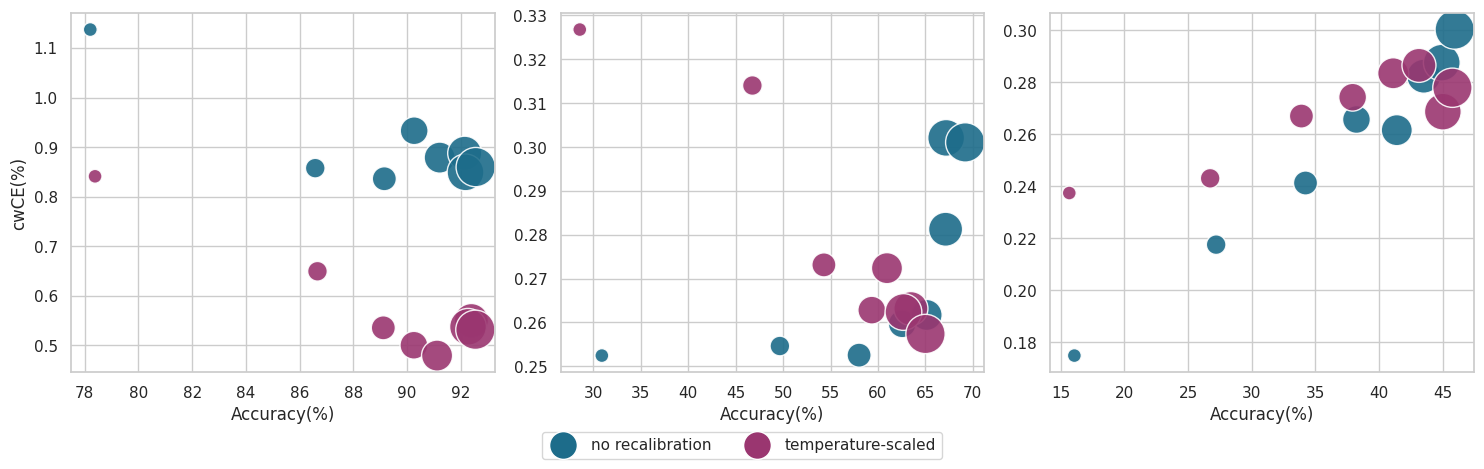

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Architecture list
list_arch = ['8:8:8:8:8','16:16:16:16:16','24:24:24:24:24','32:32:32:32:32','40:40:40:40:40',
             '48:48:48:48:48','56:56:56:56:56','64:64:64:64:64']

# Create a new column for the size of the architecture
def arch_to_size(arch):
    return sum(int(x) for x in arch.split(':'))

# Apply the architecture size and filter to the dataframes
df_imagenet = df_imagenet[df_imagenet['arch'].isin(list_arch)]
df_imagenet['size'] = df_imagenet['arch'].apply(arch_to_size)
df_imagenet_post = df_imagenet_post[df_imagenet_post['arch'].isin(list_arch)]
df_imagenet_post['size'] = df_imagenet_post['arch'].apply(arch_to_size)

df_cifar10 = df_cifar10[df_cifar10['arch'].isin(list_arch)]
df_cifar10['size'] = df_cifar10['arch'].apply(arch_to_size)
df_cifar10_post = df_cifar10_post[df_cifar10_post['arch'].isin(list_arch)]
df_cifar10_post['size'] = df_cifar10_post['arch'].apply(arch_to_size)

df_cifar100 = df_cifar100[df_cifar100['arch'].isin(list_arch)]
df_cifar100['size'] = df_cifar100['arch'].apply(arch_to_size)
df_cifar100_post = df_cifar100_post[df_cifar100_post['arch'].isin(list_arch)]
df_cifar100_post['size'] = df_cifar100_post['arch'].apply(arch_to_size)

# Define color palettes
palette_orig = sns.color_palette("crest", len(list_arch))
palette_post = sns.color_palette("flare", len(list_arch))

# Define color mapping
def arch_to_color(arch):
    return list_arch.index(arch) if arch in list_arch else None

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot for each dataframe
datasets = [
            (df_cifar10, df_cifar10_post, 'CIFAR-10'), 
            (df_cifar100, df_cifar100_post, 'CIFAR-100'),(df_imagenet, df_imagenet_post, 'ImageNet')]

size_to_label = {sum(int(x) for x in arch.split(':')): arch.split(':')[0] for arch in list_arch}




for i, (df, df_post, label) in enumerate(datasets):
    # colors_orig = df['arch'].apply(arch_to_color).apply(lambda x: palette_orig[x])
    # colors_post = df_post['arch'].apply(arch_to_color).apply(lambda x: palette_post[x])

    colors_orig = palette_orig[5]
    colors_post = palette_post[5]


    axs[i].scatter(df['acc']*100, df['cwCE_15']*100, s=df['dot_size'], c=colors_orig, alpha=0.9, edgecolors='w')
    axs[i].scatter(df_post['acc']*100, df_post['cwCE_15']*100, s=df_post['dot_size'], c=colors_post, alpha=0.9, edgecolors='w')
    axs[i].set_xlabel('Accuracy(%)')
    axs[i].set_ylabel('cwCE(%)') if i == 0 else None

# Adjust layout
# Add legend
legend_labels = ['no recalibration', 'temperature-scaled']
legend_colors = [palette_orig[5], palette_post[5]]
legend_elements = [mlines.Line2D([], [], marker='o', color='w', label=label, markerfacecolor=color, markersize=20) for label, color in zip(legend_labels, legend_colors)]
legend = fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, 0.05))

# Adjust subplots layout
fig.tight_layout(rect=[0, 0.1, 1, 1])
# plt.savefig("fig/sss_sizeplot.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Hide the last subplot
plt.savefig("fig/sss_cwce_width.pdf", dpi=300, format='pdf', bbox_inches='tight')


In [56]:
palette_orig[-1]

(0.15459955, 0.27155765, 0.4865371)